In [1]:
#Importing Required Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression,Ridge,Lasso,ElasticNet
from sklearn.metrics import r2_score,mean_squared_error, mean_absolute_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import linear_rainbow
import scipy.stats as stats
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from sklearn.feature_selection import RFECV
from sklearn.tree import DecisionTreeRegressor
from statsmodels.tools.eval_measures import rmse
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor, AdaBoostRegressor, VotingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
from statsmodels.tsa.stattools import adfuller
#from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import statsmodels
from pandas.tseries.offsets import DateOffset

In [2]:
plt.rcParams["figure.figsize"] = (18,8) # Setting the size of the images used here.

In [3]:
train = pd.read_csv('train.csv', parse_dates=['Date'])  # Training data
features = pd.read_csv('features.csv', parse_dates=['Date']) # Features
stores = pd.read_csv('stores.csv')  # Store Details

In [4]:
train_stores = pd.merge(left=train, right=stores, how='left', on='Store')  # Merging Train data and Stores Details

In [5]:
df = pd.merge(left=train_stores, right=features, how='left', on=['Store','Date','IsHoliday'])  # Merging Train data, Stores and Features
df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
0,1,1,2010-02-05,24924.50,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106
1,1,1,2010-02-12,46039.49,True,A,151315,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106
2,1,1,2010-02-19,41595.55,False,A,151315,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106
3,1,1,2010-02-26,19403.54,False,A,151315,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106
4,1,1,2010-03-05,21827.90,False,A,151315,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106


In [6]:
print(f'Total number of rows --> {df.shape[0]}')
print(f'Total number of columns --> {df.shape[1]}')

Total number of rows --> 421570
Total number of columns --> 16


In [7]:
df.info()  # Information about the columns

<class 'pandas.core.frame.DataFrame'>
Int64Index: 421570 entries, 0 to 421569
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Store         421570 non-null  int64         
 1   Dept          421570 non-null  int64         
 2   Date          421570 non-null  datetime64[ns]
 3   Weekly_Sales  421570 non-null  float64       
 4   IsHoliday     421570 non-null  bool          
 5   Type          421570 non-null  object        
 6   Size          421570 non-null  int64         
 7   Temperature   421570 non-null  float64       
 8   Fuel_Price    421570 non-null  float64       
 9   MarkDown1     150681 non-null  float64       
 10  MarkDown2     111248 non-null  float64       
 11  MarkDown3     137091 non-null  float64       
 12  MarkDown4     134967 non-null  float64       
 13  MarkDown5     151432 non-null  float64       
 14  CPI           421570 non-null  float64       
 15  Unemployment  421

In [8]:
df.describe().T  # Five Point Summary

,count,mean,std,min,25%,50%,75%,max
Store,421570.0,22.200546,12.785297,1.000,11.000000,22.00000,33.000000,45.000000
Dept,421570.0,44.260317,30.492054,1.000,18.000000,37.00000,74.000000,99.000000
Weekly_Sales,421570.0,15981.258123,22711.183519,-4988.940,2079.650000,7612.03000,20205.852500,693099.360000
Size,421570.0,136727.915739,60980.583328,34875.000,93638.000000,140167.00000,202505.000000,219622.000000
Temperature,421570.0,60.090059,18.447931,-2.060,46.680000,62.09000,74.280000,100.140000
Fuel_Price,421570.0,3.361027,0.458515,2.472,2.933000,3.45200,3.738000,4.468000
MarkDown1,150681.0,7246.420196,8291.221345,0.270,2240.270000,5347.45000,9210.900000,88646.760000
MarkDown2,111248.0,3334.628621,9475.357325,-265.760,41.600000,192.00000,1926.940000,104519.540000
MarkDown3,137091.0,1439.421384,9623.078290,-29.100,5.080000,24.60000,103.990000,141630.610000
MarkDown4,134967.0,3383.168256,6292.384031,0.220,504.220000,1481.31000,3595.040000,67474.850000


In [9]:
df.columns   # Columns present in the dataset

Index(['Store', 'Dept', 'Date', 'Weekly_Sales', 'IsHoliday', 'Type', 'Size',
       'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3',
       'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment'],
      dtype='object')

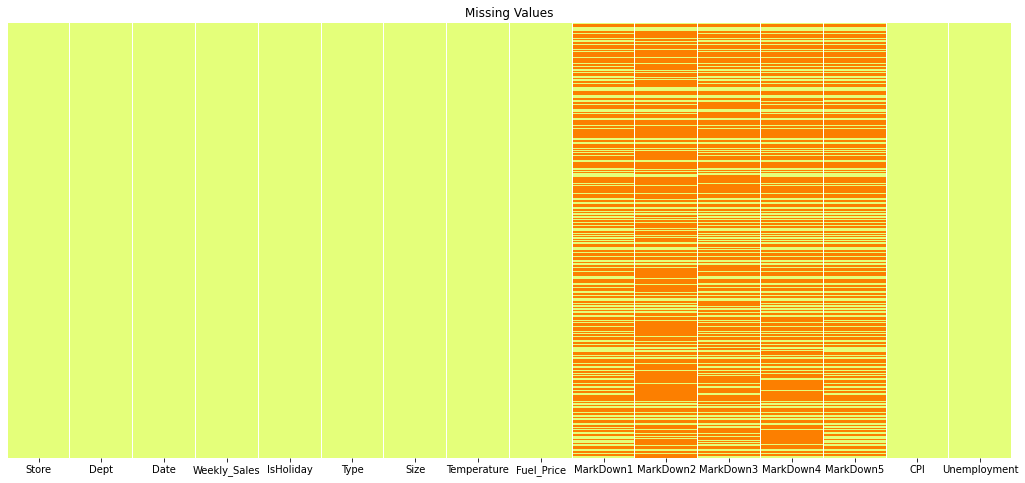

In [10]:
#Plotting a heatmap to check the missing values
sns.heatmap(data = df.isna(), yticklabels=False, cbar=False, cmap='Wistia')
plt.title('Missing Values')
plt.show()

In [11]:
#Number of missing values
df.isna().sum().sort_values(ascending=False).head()

MarkDown2    310322
MarkDown4    286603
MarkDown3    284479
MarkDown1    270889
MarkDown5    270138
dtype: int64

In [12]:
#Percentage of missing values
df.isna().sum().sort_values(ascending=False).head()/df.shape[0]*100

MarkDown2    73.611025
MarkDown4    67.984676
MarkDown3    67.480845
MarkDown1    64.257181
MarkDown5    64.079038
dtype: float64

In [13]:
#Imputing the missing values with 0 as it means there is no discount available there
df.fillna(0, inplace=True)

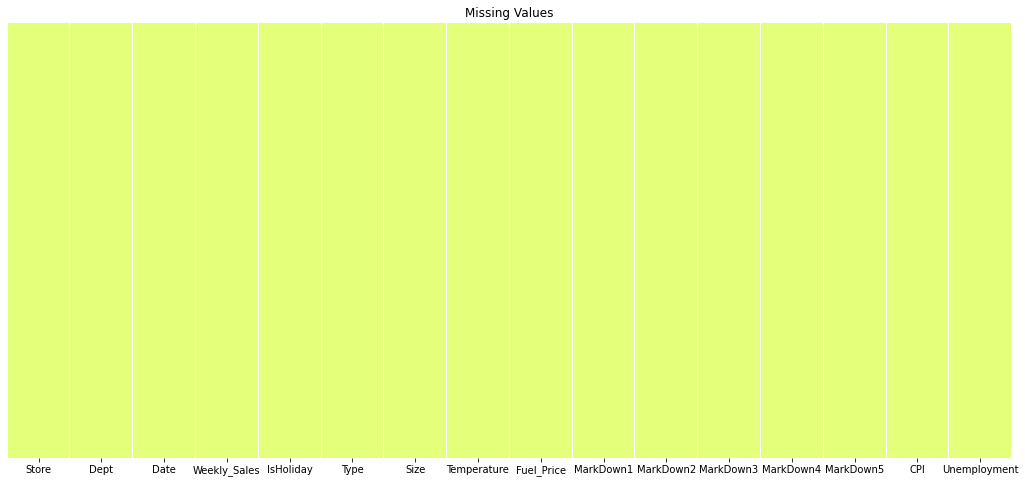

In [14]:
#Plotting a heatmap again to confirm that there are no missing values
sns.heatmap(data = df.isna(), yticklabels=False, cbar=False, cmap='Wistia')
plt.title('Missing Values')
plt.show()

In [15]:
df_markdown = df[['MarkDown1', 'MarkDown2', 'MarkDown3','MarkDown4', 'MarkDown5', 'Weekly_Sales']].copy()  # Creating a new dataframe with all MarkDowns and Weekly Sales.
df_markdown['Is_MarkDown'] = df_markdown.iloc[:,0:5].sum(axis=1).apply(lambda x: 0 if x == 0 else 1) # Add one new column is_MarkDown

In [16]:
df_is_markdown = df_markdown.loc[df_markdown['Is_MarkDown']==1, 'Weekly_Sales']  # Weekly Sales with MarkDown
df_no_markdown = df_markdown.loc[df_markdown['Is_MarkDown']==0, 'Weekly_Sales']  # Weekly Sales without MarkDown

In [17]:
df_is_markdown.shape, df_no_markdown.shape  # NUmber of records with and without MarkDown

((151432,), (270138,))

In [18]:
print(f'Average Weekly Sales with Markdown --> {df_is_markdown.mean():.2f}\nAverage Weekly Sales without Markdown --> {df_no_markdown.mean():.2f}')

Average Weekly Sales with Markdown --> 16177.02
Average Weekly Sales without Markdown --> 15871.52


In [19]:
ttest_ind(df_is_markdown, df_no_markdown)  # Two Sample Independent T Test performed on weekly sales with MarkDown andd weekly sales without MarkDown

Ttest_indResult(statistic=4.190223302926926, pvalue=2.7873670493605033e-05)

**As we can see from the ttest, there is a significant difference between the Weekly Sales with Markdown and the Weekly Sales without Markdown.**

<h2 style='font-family:rockwell; color:#06917e'> Exploratory Data Analysis</h2>

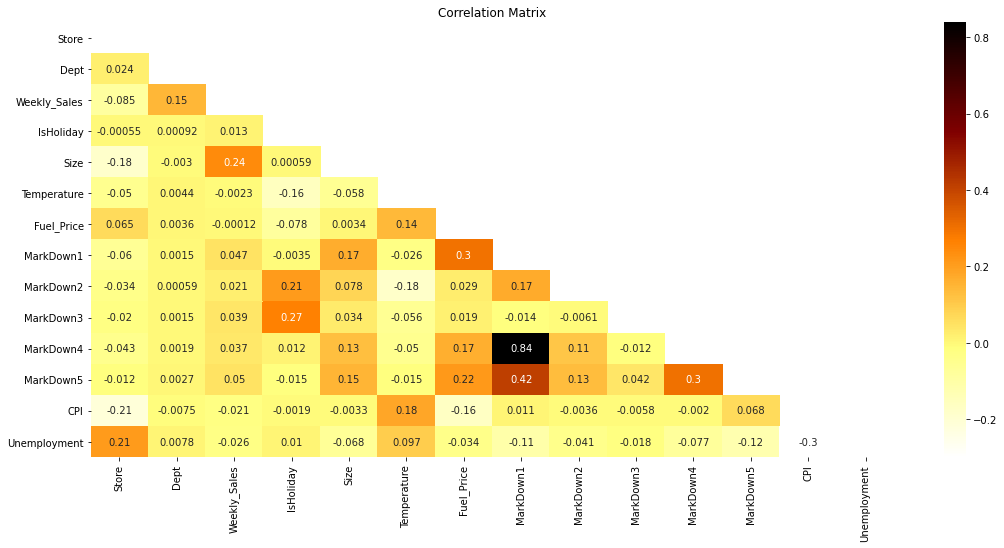

In [20]:
mask = np.triu(np.ones_like(df.corr(), dtype=bool))
sns.heatmap(data=df.corr(), annot=True, cmap='afmhot_r', mask=mask)  # Heatmap for correlation
plt.title('Correlation Matrix')
plt.show()

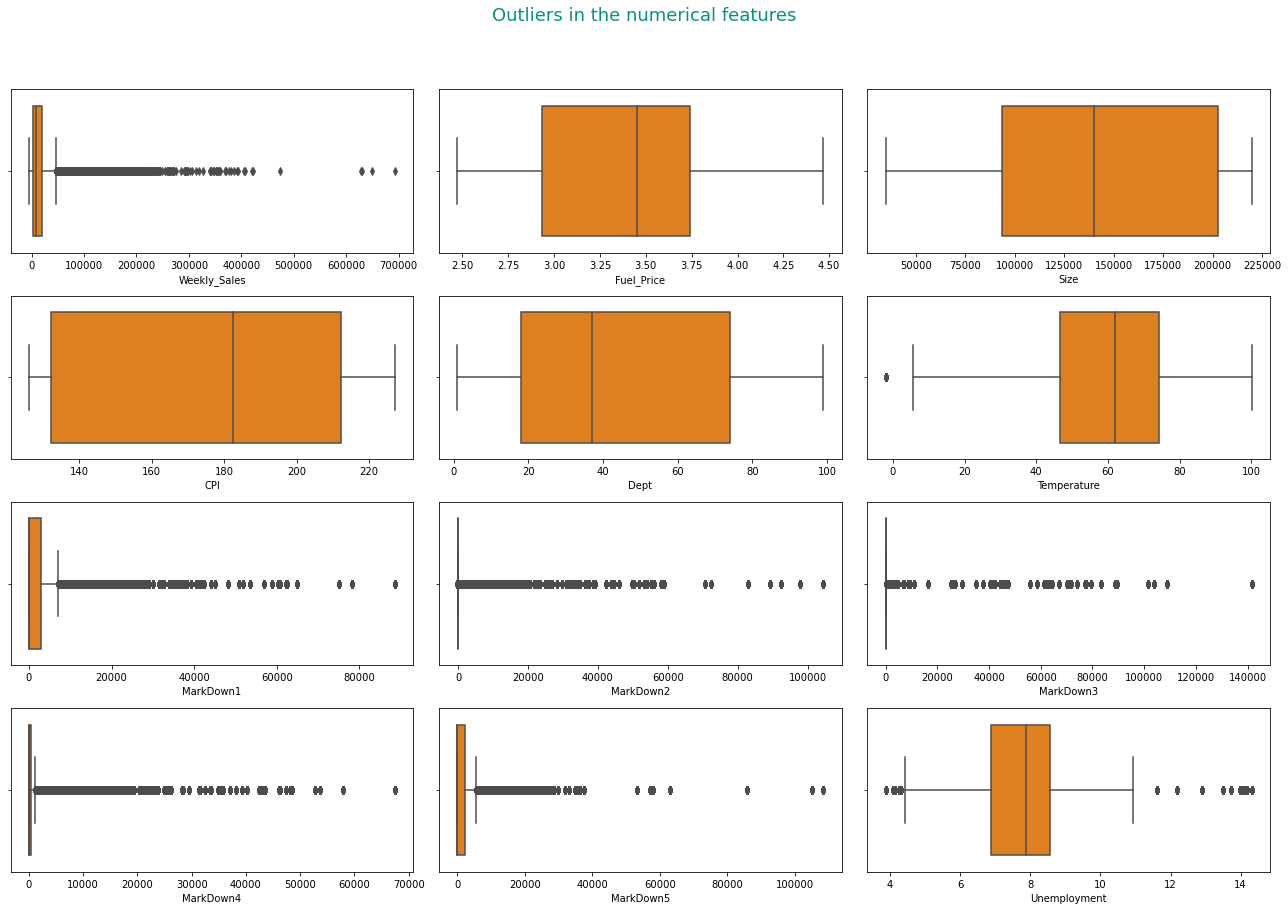

In [21]:
cols_outlier = df[['Weekly_Sales', 'Fuel_Price', 'Size', 'CPI', 'Dept', 'Temperature','MarkDown1', 'MarkDown2', 'MarkDown3',
       'MarkDown4', 'MarkDown5', 'Unemployment']]
fig, axes = plt.subplots(4,3,figsize=(18,12))
fig.suptitle('Outliers in the numerical features',fontsize=18, color = '#06917e', x = 0.5, y = 1.05)
index = [(i,j) for i in range(4) for j in range(3)]
index_count=0
for col in cols_outlier.columns:
    sns.boxplot(x=col, ax=axes[index[index_count]], data=df, palette='afmhot_r')
    index_count += 1
    plt.tight_layout()
plt.show()

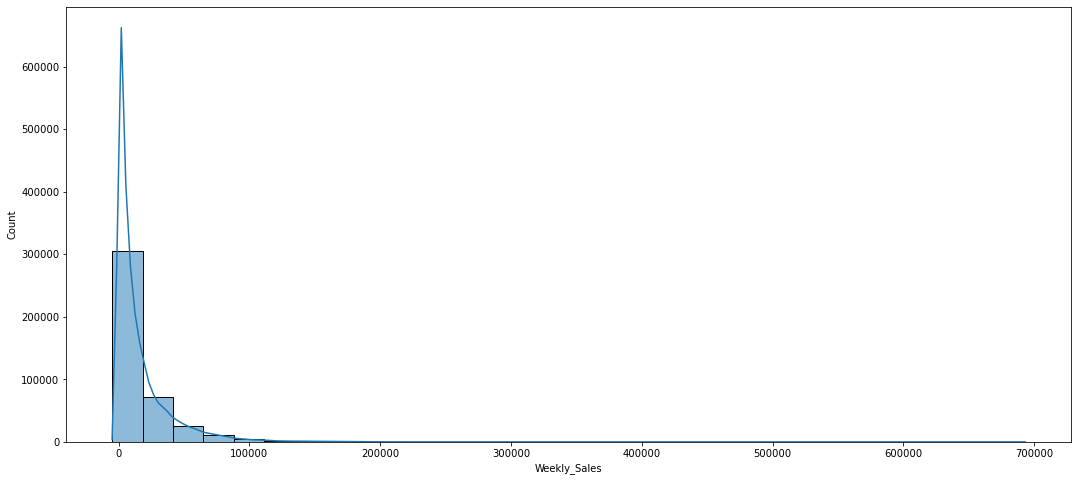

In [22]:
sns.histplot(x=df['Weekly_Sales'], bins=30, kde=True)  # Distribution of Target Variable 'Weekly_Sales'
plt.show()

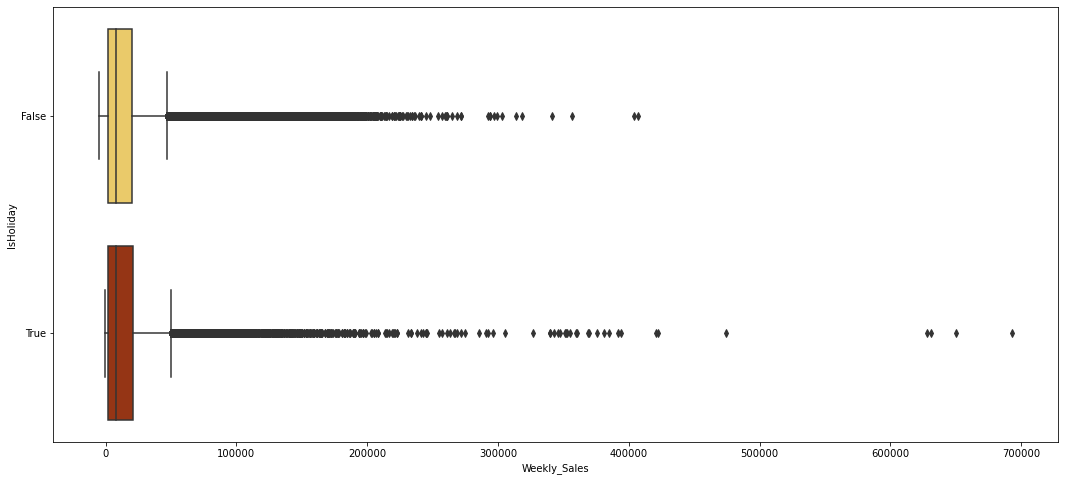

In [23]:
sns.boxplot(x='Weekly_Sales', y='IsHoliday', data=df, orient='h', palette='afmhot_r')  # Effect of IsHoliday on Weekly Sales
plt.show()

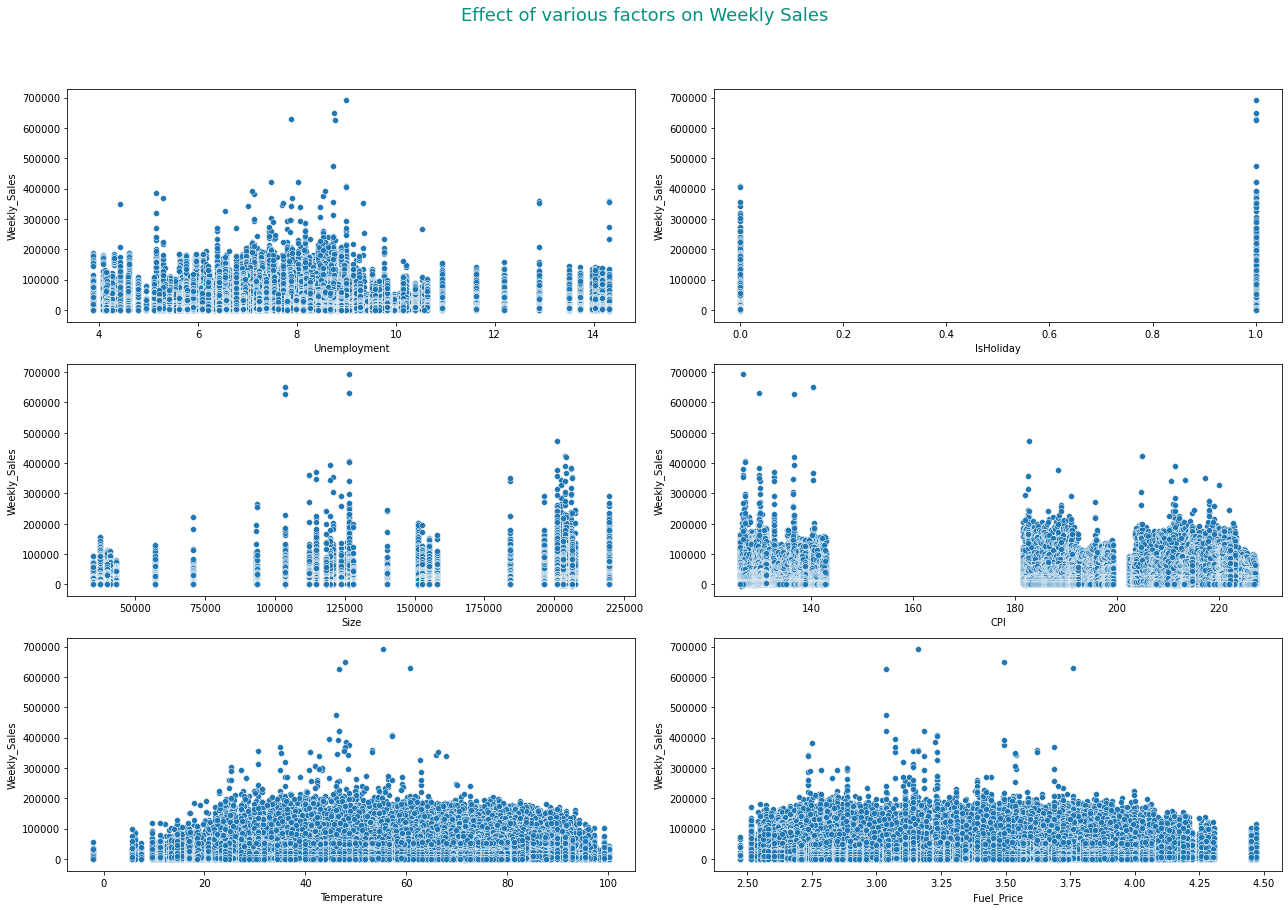

In [24]:
fig, axes = plt.subplots(3,2,figsize=(18,12))
ax_index = [(i,j) for i in range(3) for j in range(2)]
index_number = 0
fig.suptitle('Effect of various factors on Weekly Sales',fontsize=18, color = '#06917e', y = 1.05)
for i in ['Unemployment','IsHoliday','Size','CPI','Temperature','Fuel_Price']:
    sns.scatterplot(x=i, y='Weekly_Sales', data=df, ax=axes[ax_index[index_number]], palette='afmhot_r')
    index_number += 1
    plt.tight_layout()

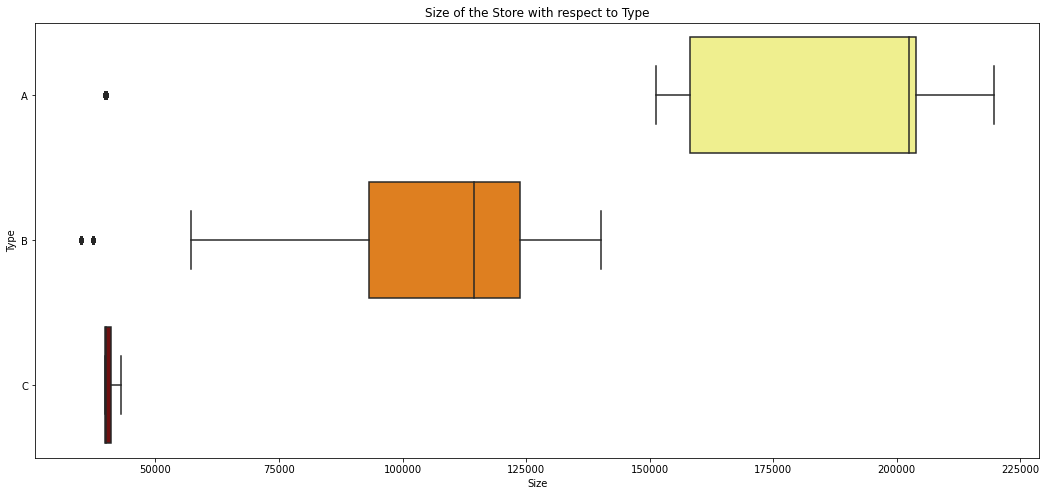

In [25]:
sns.boxplot(x='Size', y='Type', data=df, palette='afmhot_r')
plt.title('Size of the Store with respect to Type')
plt.show()

In [26]:
TypewiseSize = df.groupby(by='Type')['Size']
print("Median Size for Type A Stores --> ",TypewiseSize.get_group('A').median())
print("Median Size for Type B Stores --> ",TypewiseSize.get_group('B').median())
print("Median Size for Type C Stores --> ",TypewiseSize.get_group('C').median())

Median Size for Type A Stores -->  202505.0
Median Size for Type B Stores -->  114533.0
Median Size for Type C Stores -->  39910.0


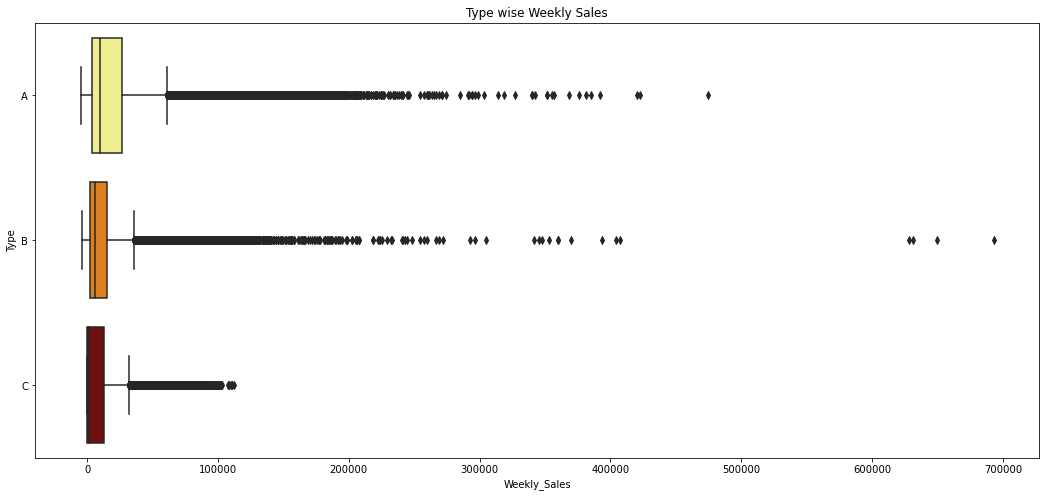

In [27]:
sns.boxplot(y='Type',x='Weekly_Sales', data=df, orient='h', palette='afmhot_r')
plt.title('Type wise Weekly Sales')
plt.show()

In [28]:
TypewiseSales = df.groupby(by='Type')['Weekly_Sales']
print("Median Weekly Sales for Type A Stores --> ",TypewiseSales.get_group('A').median())
print("Median Weekly Sales for Type B Stores --> ",TypewiseSales.get_group('B').median())
print("Median Weekly Sales for Type C Stores --> ",TypewiseSales.get_group('C').median())

Median Weekly Sales for Type A Stores -->  10105.17
Median Weekly Sales for Type B Stores -->  6187.87
Median Weekly Sales for Type C Stores -->  1149.67


**Average number of departments in each type**

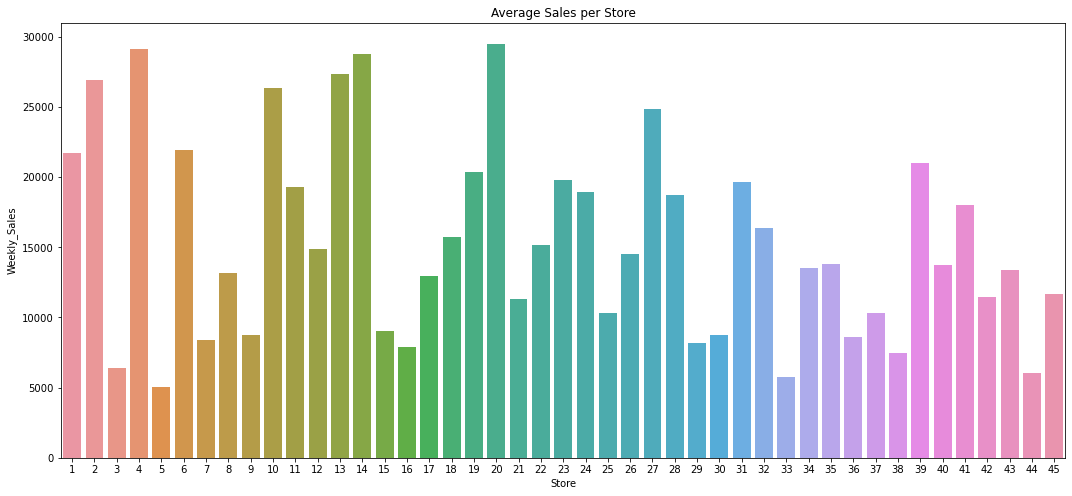

In [29]:
#Average Sales per stores
avg_sales_per_store = df.groupby(by='Store')['Weekly_Sales'].mean()
sns.barplot(x = avg_sales_per_store.index, y=avg_sales_per_store)
plt.title('Average Sales per Store')
plt.show()

In [30]:
avg_sales_per_store.sort_values(ascending = False).head()  # Top 5 most average weekly sales stores.

Store
20    29508.301592
4     29161.210415
14    28784.851727
13    27355.136891
2     26898.070031
Name: Weekly_Sales, dtype: float64

In [31]:
avg_sales_per_store.sort_values(ascending = False).tail()  # Bottom 5 less average weekly sales stores.

Store
38    7492.478460
3     6373.033983
44    6038.929814
33    5728.414053
5     5053.415813
Name: Weekly_Sales, dtype: float64

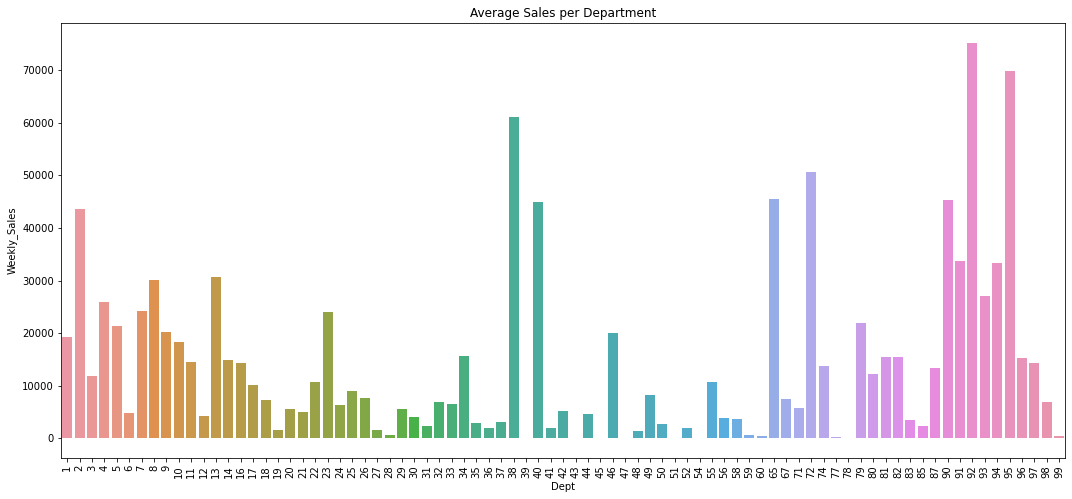

In [32]:
#Average Sales per Department
avg_sales_per_dept = df.groupby(by='Dept')['Weekly_Sales'].mean()
sns.barplot(x = avg_sales_per_dept.index, y=avg_sales_per_dept)
plt.title('Average Sales per Department')
plt.xticks(rotation = 90)
plt.show()

In [33]:
avg_sales_per_dept.sort_values().head(6)  # Bottom 6 departments with least average weekly sales. 

Dept
47    -7.682554
43     1.193333
78     7.296638
39    11.123750
51    21.931729
45    23.211586
Name: Weekly_Sales, dtype: float64

**As we can see from the above graph, few of the sales have almost no sales**

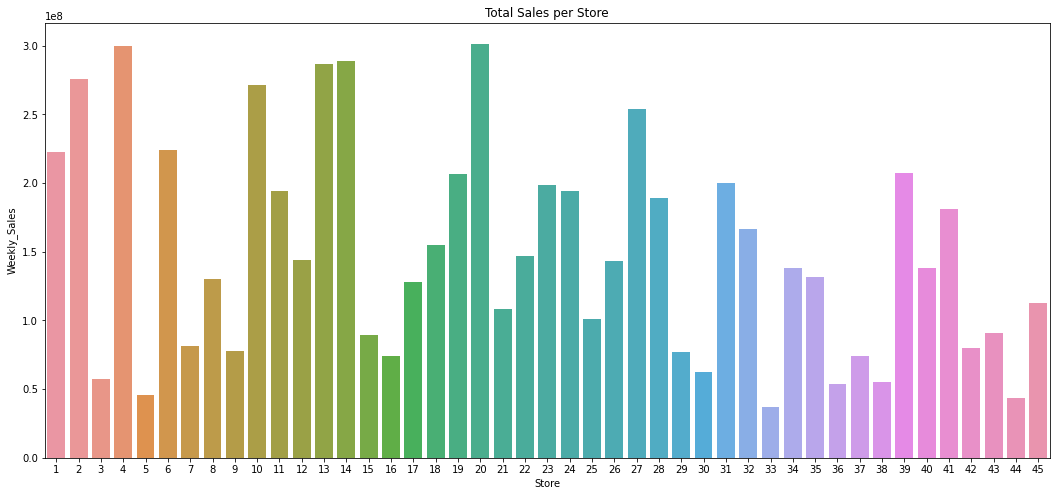

In [34]:
#Total Sales per stores
total_sales_per_store = df.groupby(by='Store')['Weekly_Sales'].sum()
sns.barplot(x = total_sales_per_store.index, y=total_sales_per_store)
plt.title('Total Sales per Store')
plt.show()

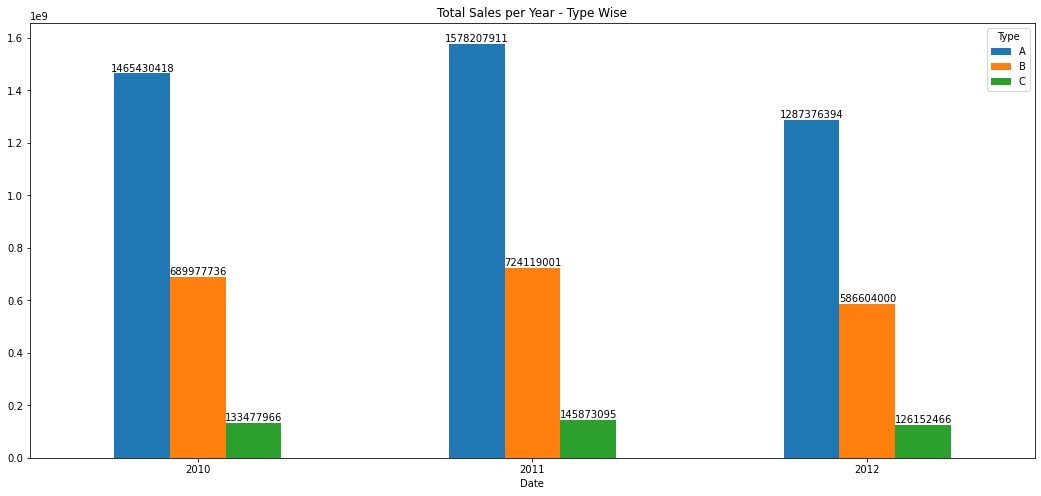

In [35]:
total_sales_per_year = df.groupby(by=[df['Date'].dt.year, 'Type'])['Weekly_Sales'].sum()
g = total_sales_per_year.unstack().plot(kind='bar')
for p in g.patches:
    g.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.085, p.get_height()),ha='center', va='bottom',color= 'black')
plt.title('Total Sales per Year - Type Wise')
plt.xticks(rotation=0)
plt.show()

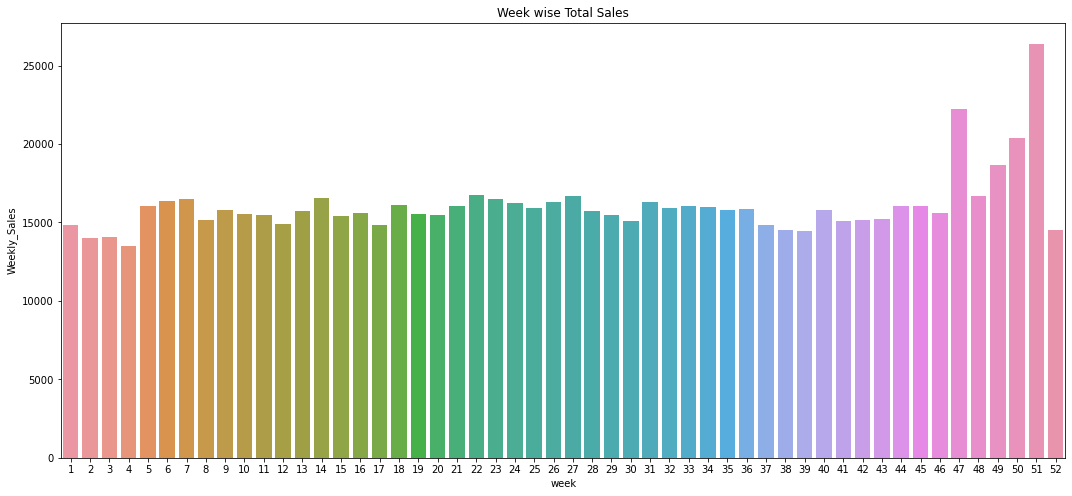

In [36]:
sns.barplot(x=df['Date'].dt.isocalendar().week, y="Weekly_Sales", data=df, ci=None)
plt.title('Week wise Total Sales')
plt.show()

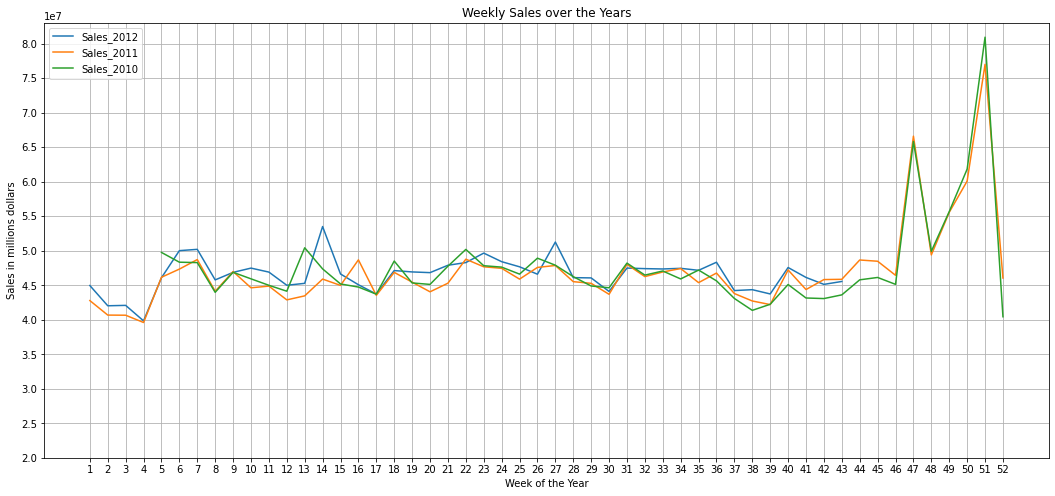

In [37]:
df_2010 = df.loc[ (df['Date'].dt.year==2010), ['Date', 'Weekly_Sales'] ].groupby(by='Date').sum()
df_2011 = df.loc[ (df['Date'].dt.year==2011), ['Date', 'Weekly_Sales'] ].groupby(by='Date').sum()
df_2012 = df.loc[ (df['Date'].dt.year==2012), ['Date', 'Weekly_Sales'] ].groupby(by='Date').sum()

a10 = pd.DataFrame(data = {'Week_num':df_2010.index.isocalendar().week , 'Sales_2010':df_2010['Weekly_Sales']})
a11 = pd.DataFrame(data = {'Week_num':df_2011.index.isocalendar().week , 'Sales_2011':df_2011['Weekly_Sales']})
a12 = pd.DataFrame(data = {'Week_num':df_2012.index.isocalendar().week , 'Sales_2012':df_2012['Weekly_Sales']})

x = pd.merge(a11, a10, how='outer', on='Week_num')
y = pd.merge(a12, x, how='outer', on='Week_num')

for i in y.columns[1:]:
    plt.plot(y['Week_num'], y[i], label=i)
plt.ylabel("Sales in millions dollars")
plt.xlabel("Week of the Year")
plt.xticks(np.arange(1,53))
plt.yticks(np.arange(20000000, 85000000, 5000000))
plt.title('Weekly Sales over the Years')
plt.legend()
plt.grid()
plt.show()

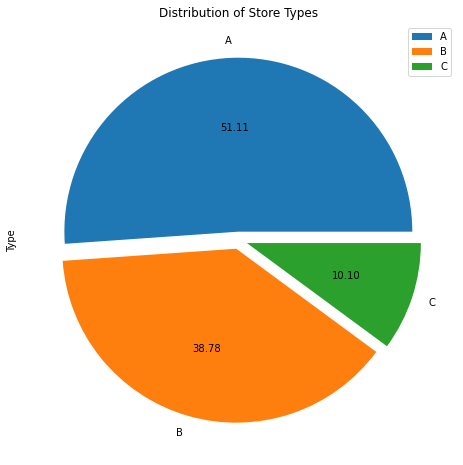

In [38]:
df['Type'].value_counts(normalize=True).plot(kind='pie', autopct='%.2f', explode=[0.05,0.05,0.05])
plt.legend(df['Type'].value_counts(normalize=True).index, loc = 'upper right')
plt.title('Distribution of Store Types')
plt.show()

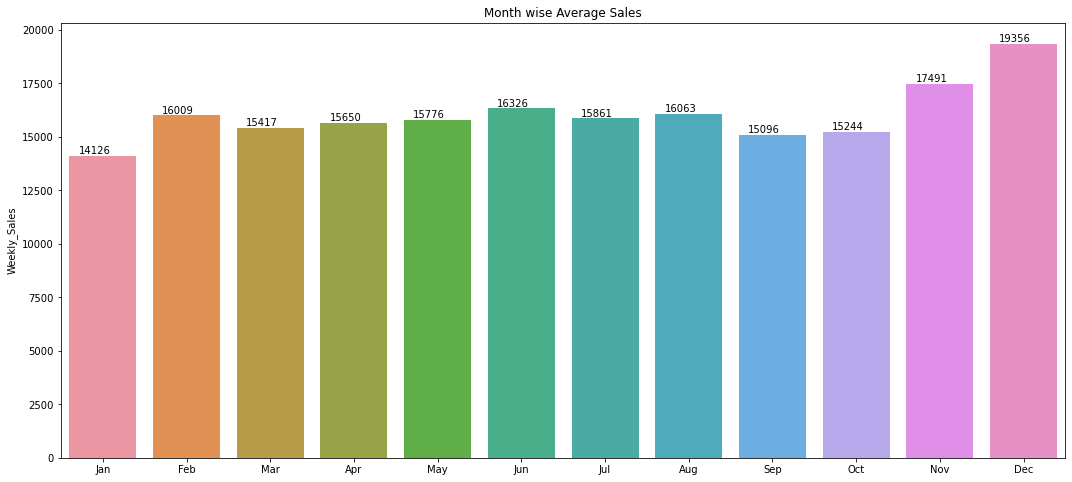

In [39]:
month_wise_avg_sales=df.groupby(df['Date'].dt.month)['Weekly_Sales'].mean()
plt.title('Month wise Average Sales')
g = sns.barplot(x=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'], y=month_wise_avg_sales)
for p in g.patches:
    g.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.3, p.get_height()),ha='center', va='bottom',color= 'black')

<h2 style='font-family:rockwell; color:#06917e'> Linear Model:</h2>

In [40]:
df1 = df.drop(columns=['Date'])  # Dropping Date column as most of the values are unique

In [41]:
df1['IsHoliday'] = df1['IsHoliday'].apply(lambda x : 1 if x==True else 0)  # Label Encoding

In [42]:
df1 = pd.get_dummies(df1, drop_first=True)  # get_dummies for 'Type' column
df1.head()

,Store,Dept,Weekly_Sales,IsHoliday,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type_B,Type_C
0,1,1,24924.50,0,151315,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,0,0
1,1,1,46039.49,1,151315,38.51,2.548,0.0,0.0,0.0,0.0,0.0,211.242170,8.106,0,0
2,1,1,41595.55,0,151315,39.93,2.514,0.0,0.0,0.0,0.0,0.0,211.289143,8.106,0,0
3,1,1,19403.54,0,151315,46.63,2.561,0.0,0.0,0.0,0.0,0.0,211.319643,8.106,0,0
4,1,1,21827.90,0,151315,46.50,2.625,0.0,0.0,0.0,0.0,0.0,211.350143,8.106,0,0


In [43]:
inp = df1.drop('Weekly_Sales',1)  # Independent Features
out = df1['Weekly_Sales']  # Dependent Features

In [44]:
sc=StandardScaler()
inp_sc=sc.fit_transform(inp.iloc[:,2:])
inp_sc=pd.DataFrame(inp_sc,columns=inp.iloc[:,2:].columns)
inp_sc = pd.concat((inp.iloc[:,0:2],inp_sc),axis=1)
inp_sc.head(2)

,Store,Dept,IsHoliday,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type_B,Type_C
0,1,1,-0.275106,0.239209,-0.963798,-1.720834,-0.427943,-0.173069,-0.084662,-0.278117,-0.395181,1.018774,0.078201,-0.795938,-0.335263
1,1,1,3.634961,0.239209,-1.169783,-1.773177,-0.427943,-0.173069,-0.084662,-0.278117,-0.395181,1.022498,0.078201,-0.795938,-0.335263


In [45]:
xtrain,xtest,ytrain,ytest = train_test_split(inp_sc,out,test_size = 0.3, random_state = 40)  # Splitting data into Train and Test

In [46]:
# Creating a base model using OLS
inpc = sm.add_constant(inp_sc)
ols = sm.OLS(out,inpc)
ols_mod = ols.fit()
ols_mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Weekly_Sales   R-squared:                       0.090
Model:                            OLS   Adj. R-squared:                  0.090
Method:                 Least Squares   F-statistic:                     2774.
Date:                Thu, 17 Dec 2020   Prob (F-statistic):               0.00
Time:                        14:59:10   Log-Likelihood:            -4.8069e+06
No. Observations:              421570   AIC:                         9.614e+06
Df Residuals:                  421554   BIC:                         9.614e+06
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         1.424e+04     89.969    158.236      0.000    1.41e+04    1.44e+04
Store         -141.2300      3.081    -45.840      0.000    -147.269    -135.191
Dept           110.2648      1.095    100.672      0.000     108.118     112.411
IsHoliday      150.9040     35.887      4.205      0.000      80.567     221.241
Size          5957.7766     58.829    101.272      0.000    5842.473    6073.080
Temperature    268.5424     36.664      7.324      0.000     196.682     340.403
Fuel_Price    -243.8422     37.325     -6.533      0.000    -316.998    -170.687
MarkDown1       56.7050     67.849      0.836      0.403     -76.278     189.688
MarkDown2      -22.7886     35.401     -0.644      0.520     -92.174      46.597
MarkDown3      633.4683     34.855     18.174      0.000     565.154     701.783
MarkDown4       35.2593     62.579      0.563      0.573     -87.395     157.913
MarkDown5      374.1572     37.560      9.962      0.000     300.540     447.774
CPI          -1050.4914     37.728    -27.844      0.000   -1124.437    -976.546
Unemployment  -423.3658     36.639    -11.555      0.000    -495.177    -351.555
Type_B        -153.6452     52.392     -2.933      0.003    -256.332     -50.958
Type_C        1734.4964     55.360     31.331      0.000    1625.993    1843.000
==============================================================================
Omnibus:                   295697.072   Durbin-Watson:                   0.120
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          8803610.428
Skew:                           3.009   Prob(JB):                         0.00
Kurtosis:                      24.563   Cond. No.                         157.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [47]:
# Linear Base Model using Scikit-learn
lr=LinearRegression()
lr.fit(xtrain,ytrain)
ypred=lr.predict(xtest)
print('R-Square Value:',r2_score(ytest,ypred))
rmse=np.sqrt(mean_squared_error(ytest,ypred))
print('RMSE:',rmse)

R-Square Value: 0.08941765117037015
RMSE: 21732.521325514008


In [48]:
#Checking for Assumptions:
#Multi-collinearity
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(inp_sc.values,i) for i in range(inp_sc.shape[1])]
vif['Features'] = inp_sc.columns
vif.sort_values('VIF', ascending= False)

,VIF,Features
6,4.133645,MarkDown1
9,3.516486,MarkDown4
3,3.091525,Size
14,2.676906,Type_C
13,2.410799,Type_B
0,2.393784,Store
1,2.226593,Dept
10,1.265348,MarkDown5
11,1.254478,CPI
5,1.247539,Fuel_Price


**As all values are less than 5, There is no multi-colinearity present in the data.**

In [49]:
#Auto Correlation
inpc = sm.add_constant(xtrain)
ols = sm.OLS(ytrain,inpc)
ols_mod = ols.fit()
ols_mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Weekly_Sales   R-squared:                       0.090
Model:                            OLS   Adj. R-squared:                  0.090
Method:                 Least Squares   F-statistic:                     1945.
Date:                Thu, 17 Dec 2020   Prob (F-statistic):               0.00
Time:                        14:59:16   Log-Likelihood:            -3.3645e+06
No. Observations:              295099   AIC:                         6.729e+06
Df Residuals:                  295083   BIC:                         6.729e+06
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         1.412e+04    107.404    131.501      0.000    1.39e+04    1.43e+04
Store         -138.0554      3.679    -37.529      0.000    -145.265    -130.845
Dept           110.8789      1.308     84.792      0.000     108.316     113.442
IsHoliday      138.9610     42.798      3.247      0.001      55.078     222.844
Size          5972.4526     70.033     85.281      0.000    5835.190    6109.715
Temperature    245.5542     43.761      5.611      0.000     159.785     331.324
Fuel_Price    -221.3917     44.568     -4.967      0.000    -308.744    -134.039
MarkDown1      -65.3565     80.869     -0.808      0.419    -223.858      93.145
MarkDown2        0.3492     42.583      0.008      0.993     -83.112      83.810
MarkDown3      701.8545     41.878     16.759      0.000     619.774     783.935
MarkDown4      115.8321     74.415      1.557      0.120     -30.019     261.684
MarkDown5      329.8054     44.584      7.397      0.000     242.421     417.190
CPI          -1023.5121     45.018    -22.735      0.000   -1111.747    -935.278
Unemployment  -408.6378     43.732     -9.344      0.000    -494.352    -322.924
Type_B        -135.8162     62.495     -2.173      0.030    -258.304     -13.328
Type_C        1724.4022     65.946     26.149      0.000    1595.150    1853.655
==============================================================================
Omnibus:                   205833.078   Durbin-Watson:                   2.003
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          5919944.586
Skew:                           2.996   Prob(JB):                         0.00
Kurtosis:                      24.108   Cond. No.                         157.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**As the value of Durbin-Watson test near 2, we can say there is no auto correlation present.**

In [50]:
#Linearity
inpc = sm.add_constant(inp_sc)
ols = sm.OLS(out,inpc)
ols_mod = ols.fit()
stat,p_value = linear_rainbow(res = ols_mod, frac = 0.5)
stat,p_value

(0.8597562735681651, 0.9999999999999999)

**As the P-value greater than 0.05, It is following linearity.**

C:\Users\Divyajeet\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


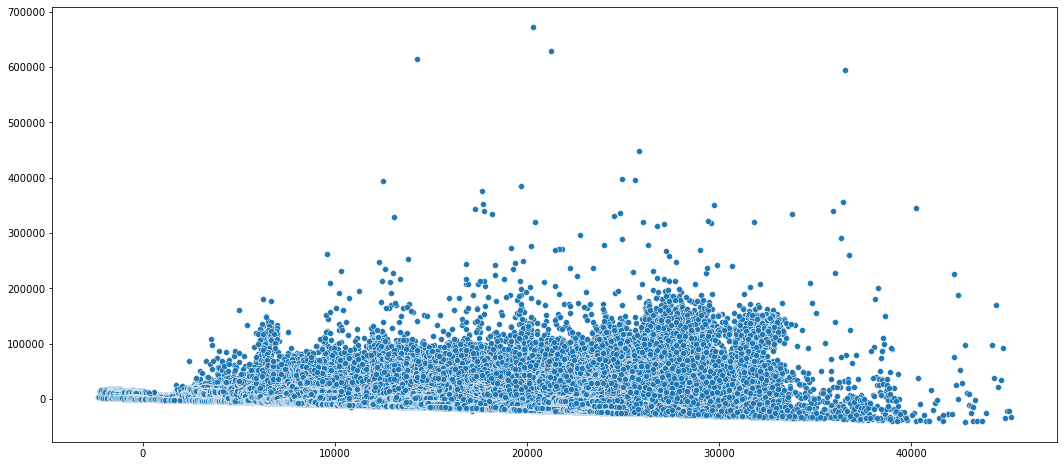

In [51]:
#Homoscedasticity
sns.scatterplot(ols_mod.predict(),ols_mod.resid)
plt.show()

**From the graph, we can say that the model is homoscedastic.**

In [52]:
#Feature Selection
lr=LinearRegression()
backward=sfs(estimator=lr,k_features='best',forward=False,scoring='r2')
sfs_backward=backward.fit(inp_sc,out)
feat_back=sfs_backward.k_feature_names_
print('Best Features using Backward Elimination:\n',feat_back)

Best Features using Backward Elimination:
 ('Store', 'Dept', 'IsHoliday', 'Size', 'MarkDown3', 'MarkDown5', 'Type_C')


In [53]:
lr=LinearRegression()
forward=sfs(estimator=lr,k_features='best',forward=True,scoring='r2')
sfs_forward=forward.fit(inp_sc,out)
feat_forw=sfs_forward.k_feature_names_
print('Best Features using Forward Selection:\n',feat_forw)

Best Features using Forward Selection:
 ('Store', 'Dept', 'IsHoliday', 'Size', 'MarkDown3', 'MarkDown5', 'Type_C')


In [54]:
lr=LinearRegression()
rfe=RFECV(estimator=lr)
rfe_mod=rfe.fit(inp_sc,out)
rfe_mod.ranking_

array([1, 1, 1, 1, 1, 1, 1, 3, 1, 2, 1, 1, 1, 1, 1])

In [55]:
rank=pd.DataFrame()
rank['Features']=xtrain.columns
rank['RANK']=rfe_mod.ranking_
feat_rfe=rank[rank['RANK']==1]['Features']
rank.sort_values(by='RANK')
print('Best Features using Recursive Feature Elimination:\n',feat_rfe)

Best Features using Recursive Feature Elimination:
 0            Store
1             Dept
2        IsHoliday
3             Size
4      Temperature
5       Fuel_Price
6        MarkDown1
8        MarkDown3
10       MarkDown5
11             CPI
12    Unemployment
13          Type_B
14          Type_C
Name: Features, dtype: object


In [56]:
feat_back =list(feat_back)
feat_forw =list(feat_forw)
feat_rfe=list(feat_rfe)

In [57]:
#Building Model using features got by Backward Elimination
lr=LinearRegression()
lr.fit(xtrain[feat_back],ytrain)
ypred=lr.predict(xtest[feat_back])

r2=r2_score(ytest,ypred)
rmse=np.sqrt(mean_squared_error(ytest,ypred))

res_back=[r2,rmse]
res_back

[0.08755036317412568, 21754.792838483816]

In [58]:
#Building Model using features got by Forward Selection
lr=LinearRegression()
lr.fit(xtrain[feat_forw],ytrain)
ypred=lr.predict(xtest[feat_forw])

r2=r2_score(ytest,ypred)
rmse=np.sqrt(mean_squared_error(ytest,ypred))

res_forw=[r2,rmse]
res_forw

[0.08755036317412568, 21754.792838483816]

In [59]:
#Building Model using features got by Recursive Feature Elimination
lr=LinearRegression()
lr.fit(xtrain[feat_rfe],ytrain)
ypred=lr.predict(xtest[feat_rfe])

r2=r2_score(ytest,ypred)
rmse=np.sqrt(mean_squared_error(ytest,ypred))

res_rfe=[r2,rmse]
res_rfe

[0.08944377359586464, 21732.209596299483]

In [60]:
score_card=pd.DataFrame()
score_card['Backward_Elmination']=res_back
score_card['Forward_Selection']=res_forw
score_card['RFE']=res_rfe
score_card.index=['Rsquare','RMSE']
score_card

,Backward_Elmination,Forward_Selection,RFE
Rsquare,0.087550,0.087550,0.089444
RMSE,21754.792838,21754.792838,21732.209596


**RFE is giving comparatively bettr result.**

In [61]:
# Cross Validation Score using RFE
lr=LinearRegression()
res=cross_val_score(lr,inp_sc[feat_rfe],out,cv=3,scoring='neg_mean_squared_error')
rmse=np.sqrt(abs(res))
be=np.mean(rmse)
ve=np.std(rmse)
cvv=np.std(rmse)/np.mean(rmse)
res_lr=[be,ve,cvv]
res_lr

[22010.209379814467, 2537.6120259986114, 0.11529249823156394]

In [62]:
inp_sc=inp_sc[feat_rfe]

In [63]:
#Regularization
# Ridge Model
ridge=Ridge()
param={'alpha':[0.0001,0.001,0.005,0.01,0.5,1,2,3,4,5,6,7,8,9,10,20,30,40,50,60,70,80,90,100]}
grid=GridSearchCV(ridge,param_grid=param,cv=3,scoring='neg_mean_squared_error')
mod_hyp=grid.fit(inp_sc,out) 
print(mod_hyp.best_params_) 
print(abs(mod_hyp.best_score_))

{'alpha': 100}
490775477.6822121


In [64]:
ridge = Ridge(alpha = 100)
res = cross_val_score(ridge,inp_sc,out,cv = 3,scoring = 'neg_mean_squared_error')
rmse = np.sqrt(abs(res))
be = np.mean(rmse) #bias error
ve = np.std(rmse) #variance error
cve = be/ve #coefficient of variance
res_rid = [be,ve,cve]
res_rid

[22007.24405311798, 2541.001154804051, 8.660855588951932]

In [65]:
# Lasso Model
lasso=Lasso()
param={'alpha':[0.0001,0.001,0.005,0.01,0.5,1,2,3,4,5,6,7,8,9,10,20,30,40,50,60,70,80,90,100]}
grid=GridSearchCV(lasso,param_grid=param,cv=3,scoring='neg_mean_squared_error')
mod_hyp=grid.fit(inp_sc,out) 
print(mod_hyp.best_params_) 
print(abs(mod_hyp.best_score_))

{'alpha': 100}
487281943.29048413


In [66]:
lasso = Lasso(alpha = 100)
res = cross_val_score(lasso,inp_sc,out,cv = 3,scoring = 'neg_mean_squared_error')
rmse = np.sqrt(abs(res))
be = np.mean(rmse) #bias error
ve = np.std(rmse) #variance error
cve = be/ve #coefficient of variance
res_las = [be,ve,cve]
res_las

[21914.608030705338, 2651.7726431632764, 8.264135346295598]

In [67]:
#ElasticNet Model
enet=ElasticNet()
param={'alpha':[0.0001,0.001,0.005,0.01,0.5,1,2,3,4,5,6,7,8,9,10,20,30,40,50,60,70,80,90,100]}
grid=GridSearchCV(enet,param_grid=param,cv=3,scoring='neg_mean_squared_error')
mod_hyp=grid.fit(inp_sc,out) 
print(mod_hyp.best_params_) 
print(abs(mod_hyp.best_score_))

{'alpha': 0.5}
478776236.2591644


In [68]:
enet = ElasticNet(alpha = 0.5)
res = cross_val_score(enet,inp_sc,out,cv = 3,scoring = 'neg_mean_squared_error')
rmse = np.sqrt(abs(res))
be = np.mean(rmse) #bias error
ve = np.std(rmse) #variance error
cve = be/ve #coefficient of variance
res_enet = [be,ve,cve]
res_enet

[21672.021805058932, 3016.5720843723634, 7.184320877771457]

In [69]:
score_card=pd.DataFrame() 
score_card['LR']=res_lr 
score_card['Ridge']=res_rid 
score_card['Lasso']=res_las 
score_card['ElasticNet']=res_enet 
score_card.index=['Bias Error','Variance Error', 'Coefficient of Variance'] 
score_card

,LR,Ridge,Lasso,ElasticNet
Bias Error,22010.209380,22007.244053,21914.608031,21672.021805
Variance Error,2537.612026,2541.001155,2651.772643,3016.572084
Coefficient of Variance,0.115292,8.660856,8.264135,7.184321


**From the models, we can see that Linear Regression model is giving comparatively better result. But the r-square value is very less.**

**So we will try Non-Linear Models.**

<h2 style='font-family:rockwell; color:#06917e'> Non-Linear Models:</h2>

### Decision Tree Regressor
#### Base Model

In [70]:
x = inp_sc
y = out

In [71]:
from statsmodels.tools.eval_measures import rmse

In [72]:
dtree=  DecisionTreeRegressor()
dtree.fit(xtrain,ytrain)

ytrain_pred = dtree.predict(xtrain)
ytest_pred = dtree.predict(xtest)

print('RMSE score of train data: ', rmse(ytrain, ytrain_pred) )
print('R^2 score of train data: ',r2_score(ytrain, ytrain_pred) )

print('RMSE score of test data: ', rmse(ytest, ytest_pred) )
print('R^2 score of test data: ', r2_score(ytest, ytest_pred) )

RMSE score of train data:  9.176386034364802e-17
R^2 score of train data:  1.0
RMSE score of test data:  6930.087403324418
R^2 score of test data:  0.9074073694321034


In [73]:
result_rmse_score = pd.DataFrame(index=['Training','Testing'])
result_r2_score = pd.DataFrame(index=['Training','Testing'])

In [74]:
result_rmse_score['DT Base Model'] = [rmse(ytrain, ytrain_pred), rmse(ytest, ytest_pred) ]
result_r2_score['DT Base Model'] = [r2_score(ytrain, ytrain_pred),r2_score(ytest, ytest_pred) ]

#### Tuning with RandomizedCV

In [75]:
dtree = DecisionTreeRegressor() # estimator


param_dist = {'max_depth' : np.arange(5,20),
             'min_samples_leaf':[15,17,20,25,30,35,40],
              'min_samples_split':[2,5,8,10,12,15],
              'criterion':['mse']}


rsearch  = RandomizedSearchCV(dtree, param_distributions = param_dist, cv=4) 

rsearch.fit(x,y)
rsearch.best_params_

{'min_samples_split': 8,
 'min_samples_leaf': 40,
 'max_depth': 12,
 'criterion': 'mse'}

#### Creating tuned model with best params of RandomizedCV object

In [76]:
dtree_rand_tuned = DecisionTreeRegressor(**rsearch.best_params_)
dtree_rand_tuned.fit(xtrain,ytrain)


ytrain_pred = dtree_rand_tuned.predict(xtrain)
print('RMSE on train data: ', rmse(ytrain, ytrain_pred) )
print('R^2 on train data: ', r2_score(ytrain, ytrain_pred))


ytest_pred = dtree_rand_tuned.predict(xtest)
print('RMSE on test data: ', rmse(ytest, ytest_pred) )
print('R^2 on test data: ', r2_score(ytest, ytest_pred))

RMSE on train data:  7369.382526606217
R^2 on train data:  0.8944577007755735
RMSE on test data:  7554.917714334461
R^2 on test data:  0.8899579998629853


In [77]:
result_rmse_score['DT Tuned Model'] = [rmse(ytrain, ytrain_pred), rmse(ytest, ytest_pred) ]
result_r2_score['DT Tuned Model'] = [r2_score(ytrain, ytrain_pred),r2_score(ytest, ytest_pred) ]

In [78]:
result_rmse_score

,DT Base Model,DT Tuned Model
Training,9.176386e-17,7369.382527
Testing,6.930087e+03,7554.917714


In [79]:
result_r2_score

,DT Base Model,DT Tuned Model
Training,1.000000,0.894458
Testing,0.907407,0.889958


## Ensemble Technique:
### Bagging:

### Random Forest
#### Base Random Forest Model

In [80]:
rf1 = RandomForestRegressor()
rf1.fit(xtrain, ytrain)


ytrain_pred =  rf1.predict(xtrain)
print('RMSE of Train Data: ', rmse(ytrain, ytrain_pred))
print('R^2 score of Train Data: ', r2_score(ytrain, ytrain_pred))


ytest_pred =  rf1.predict(xtest)
print('RMSE of Test Data: ', rmse(ytest, ytest_pred))
print('R^2 score of Test Data: ', r2_score(ytest, ytest_pred))

RMSE of Train Data:  1934.5575372781714
R^2 score of Train Data:  0.9927267644572119
RMSE of Test Data:  5060.235389474773
R^2 score of Test Data:  0.9506325792387501


In [81]:
result_rmse_score['RF Base Model'] = [rmse(ytrain, ytrain_pred),rmse(ytest, ytest_pred) ]
result_r2_score['RF Base Model'] = [r2_score(ytrain, ytrain_pred),r2_score(ytest, ytest_pred) ]

In [82]:
result_rmse_score

,DT Base Model,DT Tuned Model,RF Base Model
Training,9.176386e-17,7369.382527,1934.557537
Testing,6.930087e+03,7554.917714,5060.235389


In [83]:
result_r2_score

,DT Base Model,DT Tuned Model,RF Base Model
Training,1.000000,0.894458,0.992727
Testing,0.907407,0.889958,0.950633


#### Tuning Random forest model with RandomizedCV

In [84]:
rf2 = RandomForestRegressor()


param_dist = { 'n_estimators':sp_randint(50,100),
              'max_features': sp_randint(1,14),
              'max_depth' : sp_randint(5,20),
             'min_samples_leaf':sp_randint(10,50),
              'min_samples_split':sp_randint(2,50)}


rsearch_rf  = RandomizedSearchCV(estimator=rf2, param_distributions = param_dist, cv=4, random_state=4) 

rsearch_rf.fit(x,y)
rsearch_rf.best_params_

{'max_depth': 15,
 'max_features': 8,
 'min_samples_leaf': 15,
 'min_samples_split': 3,
 'n_estimators': 90}

In [85]:
rsearch_rf.best_score_

0.7355545046329465

#### Creating tuned model with best params of RandomizedCV object

In [86]:
rf_tuned = RandomForestRegressor(**rsearch_rf.best_params_)

rf_tuned.fit(xtrain,ytrain)

ytrain_pred = rf_tuned.predict(xtrain)
print('RMSE on train data: ', rmse(ytrain, ytrain_pred)) 
print('R^2 on train data: ', r2_score(ytrain, ytrain_pred))

ytest_pred = rf_tuned.predict(xtest)
print('RMSE on test data: ', rmse(ytest, ytest_pred))
print('R^2 on test data: ', r2_score(ytest, ytest_pred))

RMSE on train data:  6662.171964992182
R^2 on train data:  0.913742666686563
RMSE on test data:  7013.406109842499
R^2 on test data:  0.9051675494404371


In [87]:
result_rmse_score['RF Tuned Model'] = [rmse(ytrain, ytrain_pred),rmse(ytest, ytest_pred) ]
result_r2_score['RF Tuned Model'] = [r2_score(ytrain, ytrain_pred),r2_score(ytest, ytest_pred) ]

In [88]:
result_rmse_score

,DT Base Model,DT Tuned Model,RF Base Model,RF Tuned Model
Training,9.176386e-17,7369.382527,1934.557537,6662.171965
Testing,6.930087e+03,7554.917714,5060.235389,7013.406110


In [89]:
result_r2_score

,DT Base Model,DT Tuned Model,RF Base Model,RF Tuned Model
Training,1.000000,0.894458,0.992727,0.913743
Testing,0.907407,0.889958,0.950633,0.905168


In [90]:
result_rmse_score

,DT Base Model,DT Tuned Model,RF Base Model,RF Tuned Model
Training,9.176386e-17,7369.382527,1934.557537,6662.171965
Testing,6.930087e+03,7554.917714,5060.235389,7013.406110


In [125]:
rf_tuned.fit(xtrain,ytrain)
pd.DataFrame(index=xtrain.columns, data=rf_tuned.feature_importances_, columns=['feat']).sort_values(by='feat',ascending=False)

,feat
Dept,0.721631
Size,0.133897
Store,0.052518
Type_B,0.026247
CPI,0.022897
Unemployment,0.012284
Temperature,0.008022
Type_C,0.007389
MarkDown3,0.005775
Fuel_Price,0.004046


### Extra Tree Regressor
#### Base Model

In [91]:
et = ExtraTreesRegressor()
et.fit(xtrain, ytrain)

ytrain_pred =  et.predict(xtrain)
print('RMSE of Train Data: ', rmse(ytrain, ytrain_pred))
print('R^2 score of Train Data: ', r2_score(ytrain, ytrain_pred))


ytest_pred =  et.predict(xtest)
print('RMSE of Test Data: ', rmse(ytest, ytest_pred))
print('R^2 score of Test Data: ', r2_score(ytest, ytest_pred))

RMSE of Train Data:  0.21109963159534353
R^2 score of Train Data:  0.9999999999133957
RMSE of Test Data:  5322.911842695543
R^2 score of Test Data:  0.9453742332976834


In [92]:
result_rmse_score['ETR Base Model'] = [rmse(ytrain, ytrain_pred),rmse(ytest, ytest_pred) ]
result_r2_score['ETR Base Model'] = [r2_score(ytrain, ytrain_pred),r2_score(ytest, ytest_pred) ]

In [93]:
result_rmse_score

,DT Base Model,DT Tuned Model,RF Base Model,RF Tuned Model,ETR Base Model
Training,9.176386e-17,7369.382527,1934.557537,6662.171965,0.211100
Testing,6.930087e+03,7554.917714,5060.235389,7013.406110,5322.911843


In [94]:
result_r2_score

,DT Base Model,DT Tuned Model,RF Base Model,RF Tuned Model,ETR Base Model
Training,1.000000,0.894458,0.992727,0.913743,1.000000
Testing,0.907407,0.889958,0.950633,0.905168,0.945374


#### Tuning the Extra Tree Regressor

In [95]:
etr2 = ExtraTreesRegressor()


param_dist = { 'n_estimators':sp_randint(50,100),
              'max_features': sp_randint(1,14),
              'max_depth' : sp_randint(5,20),
             'min_samples_leaf':sp_randint(10,50),
              'min_samples_split':sp_randint(2,50)}


rsearch_etr  = RandomizedSearchCV(estimator=etr2, param_distributions = param_dist, cv=4, random_state=4) 

rsearch_etr.fit(x,y)
rsearch_etr.best_params_

{'max_depth': 19,
 'max_features': 11,
 'min_samples_leaf': 13,
 'min_samples_split': 2,
 'n_estimators': 71}

#### Creating tuned model with best params of RandomizedCV object

In [96]:
etr_tuned = ExtraTreesRegressor(**rsearch_etr.best_params_)
etr_tuned.fit(xtrain, ytrain)

ytrain_pred = etr_tuned.predict(xtrain)
print('RMSE on train data: ', rmse(ytrain, ytrain_pred)) 
print('R^2 on train data: ', r2_score(ytrain, ytrain_pred))

ytest_pred = etr_tuned.predict(xtest)
print('RMSE on test data: ', rmse(ytest, ytest_pred))
print('R^2 on test data: ', r2_score(ytest, ytest_pred))

RMSE on train data:  6607.66945154883
R^2 on train data:  0.9151482177042476
RMSE on test data:  7002.8661263299955
R^2 on test data:  0.9054523700779807


In [97]:
result_rmse_score['ETR Tuned Model'] = [rmse(ytrain, ytrain_pred), rmse(ytest, ytest_pred) ]
result_r2_score['ETR Tuned Model'] = [r2_score(ytrain, ytrain_pred),r2_score(ytest, ytest_pred) ]

In [98]:
result_rmse_score

,DT Base Model,DT Tuned Model,RF Base Model,RF Tuned Model,ETR Base Model,ETR Tuned Model
Training,9.176386e-17,7369.382527,1934.557537,6662.171965,0.211100,6607.669452
Testing,6.930087e+03,7554.917714,5060.235389,7013.406110,5322.911843,7002.866126


In [99]:
result_r2_score

,DT Base Model,DT Tuned Model,RF Base Model,RF Tuned Model,ETR Base Model,ETR Tuned Model
Training,1.000000,0.894458,0.992727,0.913743,1.000000,0.915148
Testing,0.907407,0.889958,0.950633,0.905168,0.945374,0.905452


In [120]:
etr_tuned.fit(xtrain, ytrain)
etr_tuned.feature_importances_

array([3.87588764e-02, 7.88644319e-01, 2.35798230e-03, 9.85464418e-02,
       6.91002318e-03, 3.10809145e-03, 4.35400338e-04, 1.63320697e-04,
       1.59292164e-03, 2.09224684e-04, 6.09605071e-04, 2.03215863e-02,
       8.58424708e-03, 2.37669571e-02, 5.99100321e-03])

In [124]:
pd.DataFrame(index=xtrain.columns, data=etr_tuned.feature_importances_, columns=['feat']).sort_values(by='feat',ascending=False)

,feat
Dept,0.788644
Size,0.098546
Store,0.038759
Type_B,0.023767
CPI,0.020322
Unemployment,0.008584
Temperature,0.006910
Type_C,0.005991
Fuel_Price,0.003108
IsHoliday,0.002358


### Boosting:
#### AdaBoost:

In [100]:
ada = AdaBoostRegressor(random_state=48)
ada.fit(xtrain,ytrain)

ytrain_pred = ada.predict(xtrain)
print('RMSE on train data: ', rmse(ytrain, ytrain_pred)) 
print('R^2 on train data: ', r2_score(ytrain, ytrain_pred))

ytest_pred = ada.predict(xtest)
print('RMSE on test data: ', rmse(ytest, ytest_pred))
print('R^2 on test data: ', r2_score(ytest, ytest_pred))

RMSE on train data:  23359.000426589242
R^2 on train data:  -0.0604076682759771
RMSE on test data:  23399.317349624947
R^2 on test data:  -0.05561456440063117


In [101]:
result_rmse_score['AdaBoost'] = [rmse(ytrain, ytrain_pred), rmse(ytest, ytest_pred) ]
result_r2_score['AdaBoost'] = [r2_score(ytrain, ytrain_pred),r2_score(ytest, ytest_pred) ]

#### Gradient Boost:

In [102]:
grad = GradientBoostingRegressor(random_state=48)
grad.fit(xtrain,ytrain)

ytrain_pred = grad.predict(xtrain)
print('RMSE on train data: ', rmse(ytrain, ytrain_pred)) 
print('R^2 on train data: ', r2_score(ytrain, ytrain_pred))

ytest_pred = grad.predict(xtest)
print('RMSE on test data: ', rmse(ytest, ytest_pred))
print('R^2 on test data: ', r2_score(ytest, ytest_pred))

RMSE on train data:  11456.947231513415
R^2 on train data:  0.7449048650189247
RMSE on test data:  11581.844197045844
R^2 on test data:  0.7413845686505431


In [103]:
result_rmse_score['Gradient Boost'] = [rmse(ytrain, ytrain_pred), rmse(ytest, ytest_pred) ]
result_r2_score['Gradient Boost'] = [r2_score(ytrain, ytrain_pred),r2_score(ytest, ytest_pred) ]

#### LightGBM:

In [104]:
lgbmr = LGBMRegressor(random_state=48)
lgbmr.fit(xtrain,ytrain)

ytrain_pred = lgbmr.predict(xtrain)
print('RMSE on train data: ', rmse(ytrain, ytrain_pred)) 
print('R^2 on train data: ', r2_score(ytrain, ytrain_pred))

ytest_pred = lgbmr.predict(xtest)
print('RMSE on test data: ', rmse(ytest, ytest_pred))
print('R^2 on test data: ', r2_score(ytest, ytest_pred))

RMSE on train data:  7439.026334717241
R^2 on train data:  0.8924534352451153
RMSE on test data:  7597.771461168725
R^2 on test data:  0.8887060771666904


In [105]:
result_rmse_score['LightGBM'] = [rmse(ytrain, ytrain_pred), rmse(ytest, ytest_pred) ]
result_r2_score['LightGBM'] = [r2_score(ytrain, ytrain_pred),r2_score(ytest, ytest_pred) ]

In [128]:
lgbmr.fit(xtrain, ytrain)
lgbmr.feature_importances_

array([ 378, 1648,   16,  347,  112,   65,    5,   12,   87,   28,    8,
        160,   78,   32,   24])

In [129]:
pd.DataFrame(index=xtrain.columns, data=lgbmr.feature_importances_, columns=['feat']).sort_values(by='feat',ascending=False)

,feat
Dept,1648
Store,378
Size,347
CPI,160
Temperature,112
MarkDown3,87
Unemployment,78
Fuel_Price,65
Type_B,32
MarkDown4,28


#### XGBoost:

In [106]:
xg = XGBRegressor(random_state=48)
xg.fit(xtrain,ytrain)

ytrain_pred = xg.predict(xtrain)
print('RMSE on train data: ', rmse(ytrain, ytrain_pred)) 
print('R^2 on train data: ', r2_score(ytrain, ytrain_pred))

ytest_pred = xg.predict(xtest)
print('RMSE on test data: ', rmse(ytest, ytest_pred))
print('R^2 on test data: ', r2_score(ytest, ytest_pred))

RMSE on train data:  5983.411335991637
R^2 on train data:  0.9304235813532922
RMSE on test data:  6509.169529465796
R^2 on test data:  0.9183135233729139


In [107]:
result_rmse_score['XGBoost'] = [rmse(ytrain, ytrain_pred), rmse(ytest, ytest_pred) ]
result_r2_score['XGBoost'] = [r2_score(ytrain, ytrain_pred),r2_score(ytest, ytest_pred) ]

In [126]:
xg.fit(xtrain, ytrain)
xg.feature_importances_

array([0.06527067, 0.23038723, 0.04390846, 0.2331905 , 0.01839564,
       0.00921594, 0.00414202, 0.00474817, 0.04823539, 0.01091119,
       0.00658868, 0.0320777 , 0.01128907, 0.26731306, 0.01432624],
      dtype=float32)

In [127]:
pd.DataFrame(index=xtrain.columns, data=xg.feature_importances_, columns=['feat']).sort_values(by='feat',ascending=False)

,feat
Type_B,0.267313
Size,0.233191
Dept,0.230387
Store,0.065271
MarkDown3,0.048235
IsHoliday,0.043908
CPI,0.032078
Temperature,0.018396
Type_C,0.014326
Unemployment,0.011289


### K-Nearest Neighbor Regressor:

In [108]:
from sklearn.neighbors import KNeighborsRegressor

In [109]:
knn = KNeighborsRegressor()
knn.fit(xtrain,ytrain)

ytrain_pred = knn.predict(xtrain)
print('RMSE on train data: ', rmse(ytrain, ytrain_pred)) 
print('R^2 on train data: ', r2_score(ytrain, ytrain_pred))

ytest_pred = knn.predict(xtest)
print('RMSE on test data: ', rmse(ytest, ytest_pred))
print('R^2 on test data: ', r2_score(ytest, ytest_pred))

RMSE on train data:  7688.270596395717
R^2 on train data:  0.8851260192108348
RMSE on test data:  9485.531688140423
R^2 on test data:  0.8265308074423786


In [110]:
result_rmse_score['KNN'] = [rmse(ytrain, ytrain_pred), rmse(ytest, ytest_pred) ]
result_r2_score['KNN'] = [r2_score(ytrain, ytrain_pred),r2_score(ytest, ytest_pred) ]

### RMSE Scorecard:

In [111]:
result_rmse_score

,DT Base Model,DT Tuned Model,RF Base Model,RF Tuned Model,ETR Base Model,ETR Tuned Model,AdaBoost,Gradient Boost,LightGBM,XGBoost,KNN
Training,9.176386e-17,7369.382527,1934.557537,6662.171965,0.211100,6607.669452,23359.000427,11456.947232,7439.026335,5983.411336,7688.270596
Testing,6.930087e+03,7554.917714,5060.235389,7013.406110,5322.911843,7002.866126,23399.317350,11581.844197,7597.771461,6509.169529,9485.531688


### R-square Scorecard:

In [112]:
result_r2_score

,DT Base Model,DT Tuned Model,RF Base Model,RF Tuned Model,ETR Base Model,ETR Tuned Model,AdaBoost,Gradient Boost,LightGBM,XGBoost,KNN
Training,1.000000,0.894458,0.992727,0.913743,1.000000,0.915148,-0.060408,0.744905,0.892453,0.930424,0.885126
Testing,0.907407,0.889958,0.950633,0.905168,0.945374,0.905452,-0.055615,0.741385,0.888706,0.918314,0.826531


**As we are getting best result for Random Forest Regressor and LightGBM, we will use these two ensemble methods in stacking to get best result.**

## Stacking Algorithms

In [113]:
rf_tuned = RandomForestRegressor(**rsearch_rf.best_params_)
etr_tuned = ExtraTreesRegressor(**rsearch_etr.best_params_)
lgbmr = LGBMRegressor(random_state=48)
xg = XGBRegressor(random_state=48)

estimators = [('rf_tuned', rf_tuned),('etr_tuned',etr_tuned),('lgbmr', lgbmr), ('xg',xg)]

stack1 = VotingRegressor(estimators=estimators)

stack1.fit(xtrain, ytrain)

ytrain_pred = stack1.predict(xtrain)
print('RMSE on train data: ', rmse(ytrain, ytrain_pred)) 
print('R^2 on train data: ', r2_score(ytrain, ytrain_pred))

ytest_pred = stack1.predict(xtest)
print('RMSE on test data: ', rmse(ytest, ytest_pred))
print('R^2 on test data: ', r2_score(ytest, ytest_pred))

result_rmse_score['Stacked Model'] = [rmse(ytrain, ytrain_pred), rmse(ytest, ytest_pred) ]
result_r2_score['Stacked Model'] = [r2_score(ytrain, ytrain_pred),r2_score(ytest, ytest_pred) ]

RMSE on train data:  6239.8492181430165
R^2 on train data:  0.9243319501676223
RMSE on test data:  6599.209179215722
R^2 on test data:  0.9160379975126497


### RMSE Scorecard:

In [114]:
result_rmse_score

,DT Base Model,DT Tuned Model,RF Base Model,RF Tuned Model,ETR Base Model,ETR Tuned Model,AdaBoost,Gradient Boost,LightGBM,XGBoost,KNN,Stacked Model
Training,9.176386e-17,7369.382527,1934.557537,6662.171965,0.211100,6607.669452,23359.000427,11456.947232,7439.026335,5983.411336,7688.270596,6239.849218
Testing,6.930087e+03,7554.917714,5060.235389,7013.406110,5322.911843,7002.866126,23399.317350,11581.844197,7597.771461,6509.169529,9485.531688,6599.209179


### R-square Scorecard:

In [115]:
result_r2_score

,DT Base Model,DT Tuned Model,RF Base Model,RF Tuned Model,ETR Base Model,ETR Tuned Model,AdaBoost,Gradient Boost,LightGBM,XGBoost,KNN,Stacked Model
Training,1.000000,0.894458,0.992727,0.913743,1.000000,0.915148,-0.060408,0.744905,0.892453,0.930424,0.885126,0.924332
Testing,0.907407,0.889958,0.950633,0.905168,0.945374,0.905452,-0.055615,0.741385,0.888706,0.918314,0.826531,0.916038


### Time Series

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels as sm
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import r2_score, mean_absolute_error
from pandas.tseries.offsets import DateOffset
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation, performance_metrics
from pandas.plotting import autocorrelation_plot

In [13]:
df = pd.read_csv('train.csv', parse_dates=['Date'])
df.drop(['Store','Dept','IsHoliday'],1,inplace=True)

In [14]:
df.head(2)

,Date,Weekly_Sales
0,2010-02-05,24924.50
1,2010-02-12,46039.49


In [15]:
wdf = df.groupby('Date').sum()
wdf.head(2)

,Weekly_Sales
Date,
2010-02-05,49750740.50
2010-02-12,48336677.63


In [16]:
wdf.shape

(143, 1)

In [17]:
pd.set_option('display.float_format','{:.2f}'.format)
wdf.describe()

,Weekly_Sales
count,143.00
mean,47113419.49
std,5444206.20
min,39599852.99
25%,44880587.54
50%,46243899.58
75%,47792024.64
max,80931415.60


#### Visualizing the data:

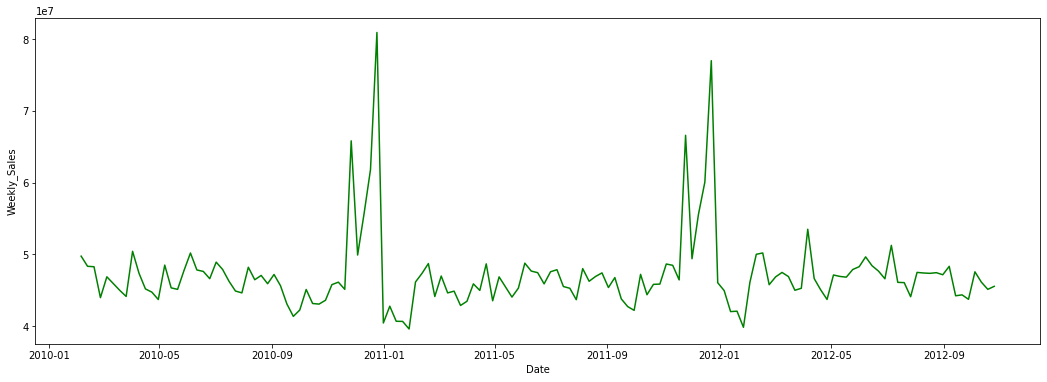

In [18]:
plt.figure(figsize=(18,6))
ax = sns.lineplot(x=wdf.index, y=wdf['Weekly_Sales'], color='green')

In [19]:
# Testing For Stationarity
test_result=adfuller(wdf['Weekly_Sales'])

In [20]:
#Ho: It is non stationary
#H1: It is stationary

def adfuller_test(sales):
    result=adfuller(sales)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")
    

In [21]:
adfuller_test(wdf['Weekly_Sales'])

ADF Test Statistic : -5.90829795718632
p-value : 2.675979158986205e-07
#Lags Used : 4
Number of Observations Used : 138
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


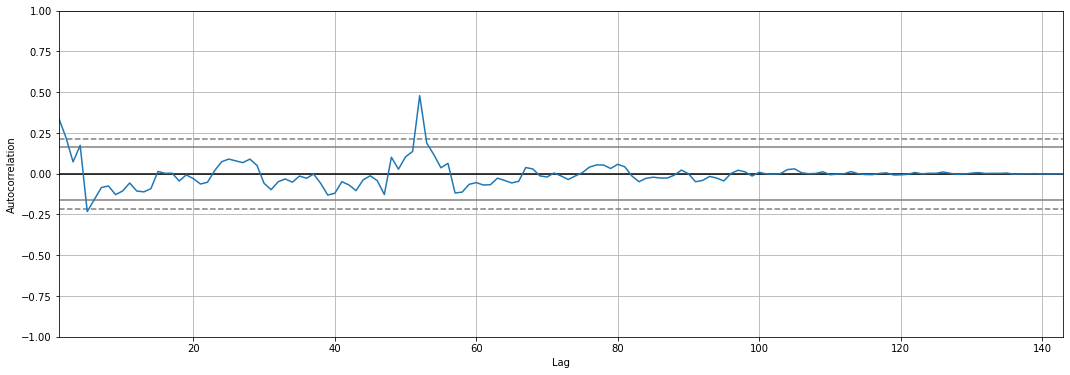

In [22]:
plt.figure(figsize=(18,6))
autocorrelation_plot(wdf['Weekly_Sales'])
plt.show()

In [23]:
wdf['Sales First Difference'] = wdf['Weekly_Sales'] - wdf['Weekly_Sales'].shift(1)

In [24]:
wdf['Seasonal First Difference']=wdf['Weekly_Sales'] - wdf['Weekly_Sales'].shift(52)

In [25]:
wdf1 = wdf[~wdf['Seasonal First Difference'].isna()].copy(deep=True)

In [26]:
wdf1.shape

(91, 3)

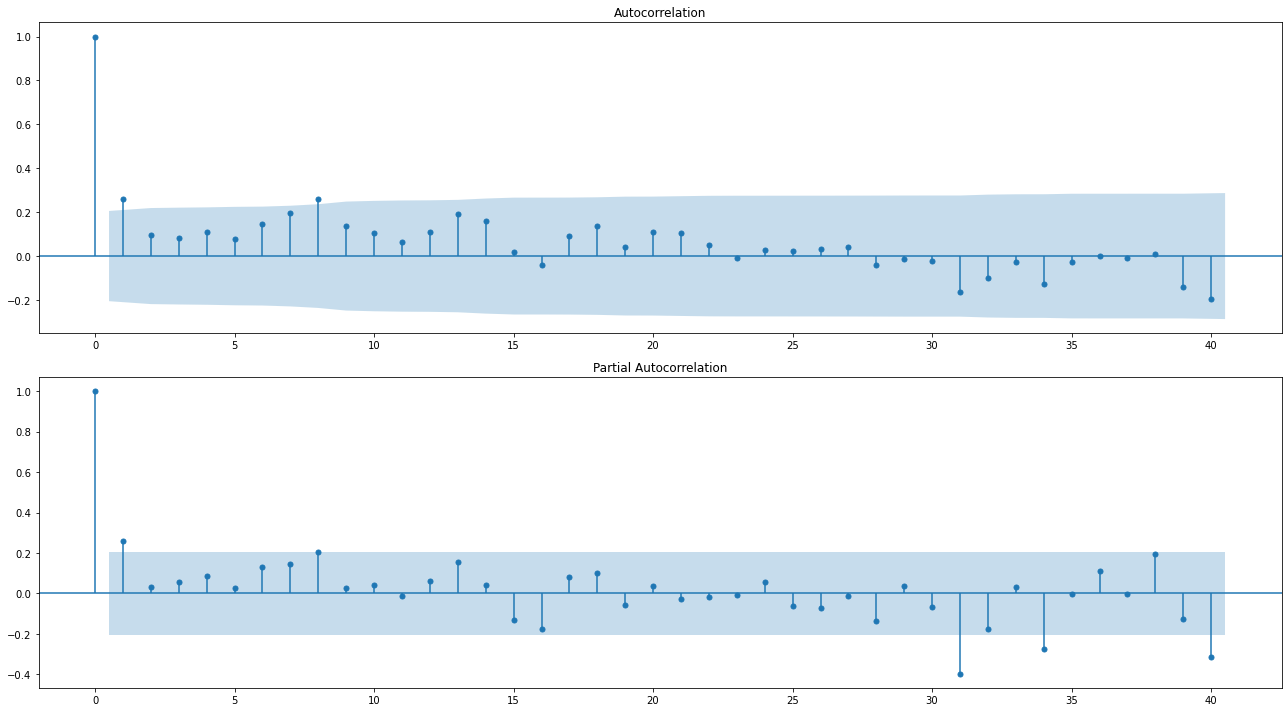

In [27]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
fig = plt.figure(figsize=(18,10))
ax1 = fig.add_subplot(211)
fig = plot_acf(wdf['Seasonal First Difference'].iloc[52:],lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(wdf['Seasonal First Difference'].iloc[52:],lags=40,ax=ax2)
plt.tight_layout()

## ARIMA:

In [28]:
# For non-seasonal data
#p=1, d=1, q=0 or 1  #p=2, d=1, q=2
model=ARIMA(wdf['Weekly_Sales'],order=(2,1,2))
model_fit=model.fit()

C:\Users\shad3\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  warnings.warn('No frequency information was'
C:\Users\shad3\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  warnings.warn('No frequency information was'
C:\Users\shad3\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  warnings.warn('No frequency information was'


In [29]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           Weekly_Sales   No. Observations:                  143
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -2404.213
Date:                Thu, 17 Dec 2020   AIC                           4818.427
Time:                        18:18:12   BIC                           4833.206
Sample:                    02-05-2010   HQIC                          4824.433
                         - 10-26-2012                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2774      0.258     -1.075      0.282      -0.783       0.228
ar.L2          0.4636      0.100      4.622      0.000       0.267       0.660
ma.L1         -0.2369      0.270     -0.878      0.380      -0.765       0.292
ma.L2         -0.7238      0.232     -3.124      0.002      -1.178      -0.270
sigma2      3.145e+13   4.07e-14   7.72e+26      0.000    3.14e+13    3.14e+13
===================================================================================
Ljung-Box (L1) (Q):                   0.45   Jarque-Bera (JB):               458.87
Prob(Q):                              0.50   Prob(JB):                         0.00
Heteroskedasticity (H):               0.46   Skew:                             1.13
Prob(H) (two-sided):                  0.01   Kurtosis:                        11.51
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.59e+41. Standard errors may be unstable.
"""

<AxesSubplot:xlabel='Date'>

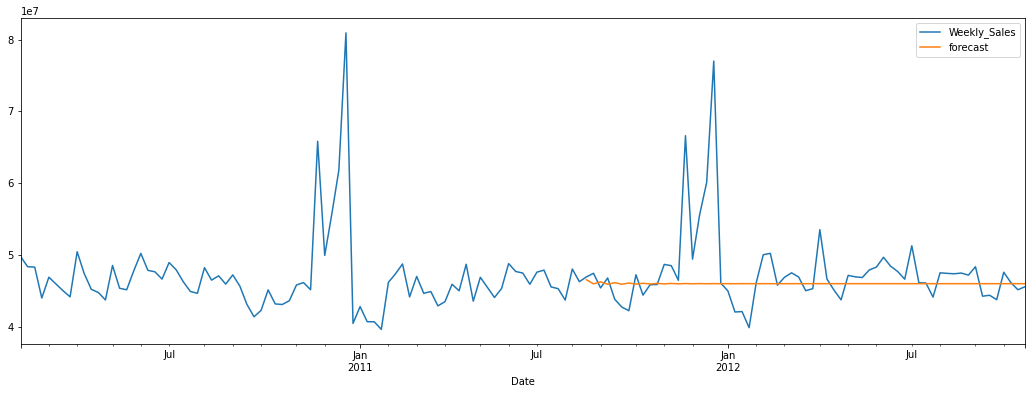

In [30]:
wdf['forecast']=model_fit.predict(start=80,end=142,dynamic=True)
wdf[['Weekly_Sales','forecast']].plot(figsize=(18,6))

## SARIMAX:

In [34]:
import statsmodels

In [35]:
model=statsmodels.tsa.statespace.sarimax.SARIMAX(wdf['Weekly_Sales'],order=(1, 1, 1),seasonal_order=(1,1,1,52))
results=model.fit()

C:\Users\shad3\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  warnings.warn('No frequency information was'
C:\Users\shad3\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  warnings.warn('No frequency information was'
C:\Users\shad3\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:865: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


0.8448167443315067

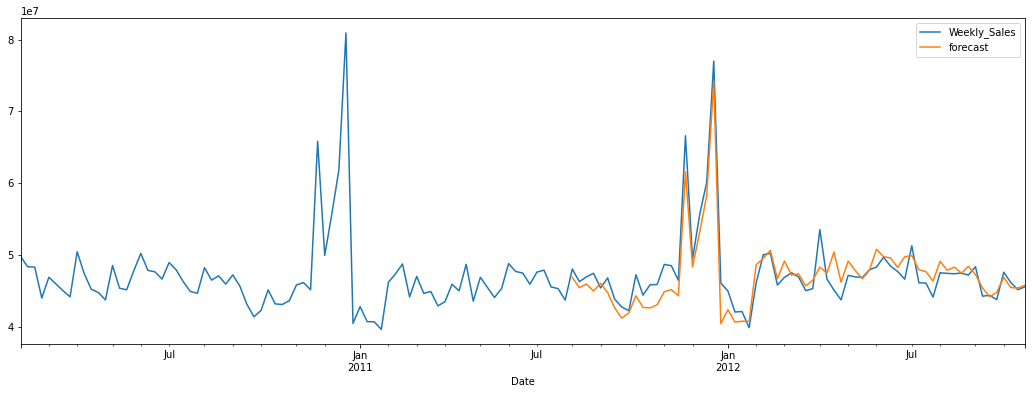

In [36]:
wdf['forecast']=results.predict(start=78,end=142,dynamic=True)
wdf[['Weekly_Sales','forecast']].plot(figsize=(18,6))
r2_score(wdf[~wdf['forecast'].isna()]['Weekly_Sales'],wdf[~wdf['forecast'].isna()]['forecast'])

In [37]:
np.sqrt(mean_absolute_error(wdf[~wdf['forecast'].isna()]['Weekly_Sales'],wdf[~wdf['forecast'].isna()]['forecast']))

1279.7849587720593

In [38]:
r2_score(wdf[~wdf['forecast'].isna()]['Weekly_Sales'],wdf[~wdf['forecast'].isna()]['forecast'])

0.8448167443315067

In [39]:
future_dates=[wdf.index[-1]+ DateOffset(weeks=x)for x in range(0,52)]

In [40]:
future_datest_df=pd.DataFrame(index=future_dates[1:],columns=wdf.columns)

In [41]:
future_df=pd.concat([wdf,future_datest_df])

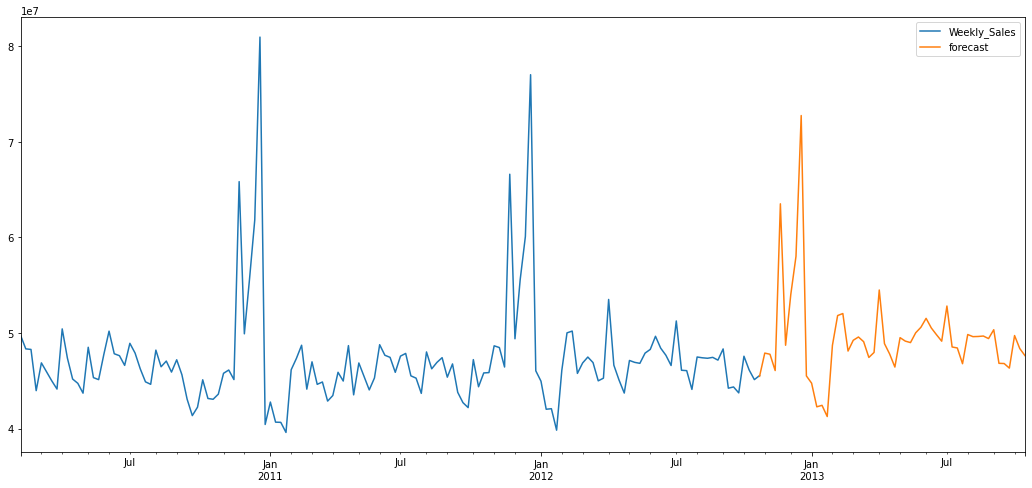

In [42]:
future_df['forecast'] = results.predict(start = 142, end = 194, dynamic= True)  
future_df[['Weekly_Sales', 'forecast']].plot(figsize=(18, 8)) 
plt.show()

### Seasonal Decompose:

In [43]:
import statsmodels.api as sm
seas_d=sm.tsa.seasonal_decompose(wdf['Weekly_Sales'],model='add',freq=7);

<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
<ipython-input-43-921a0fd498b3>:2: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  seas_d=sm.tsa.seasonal_decompose(wdf['Weekly_Sales'],model='add',freq=7);


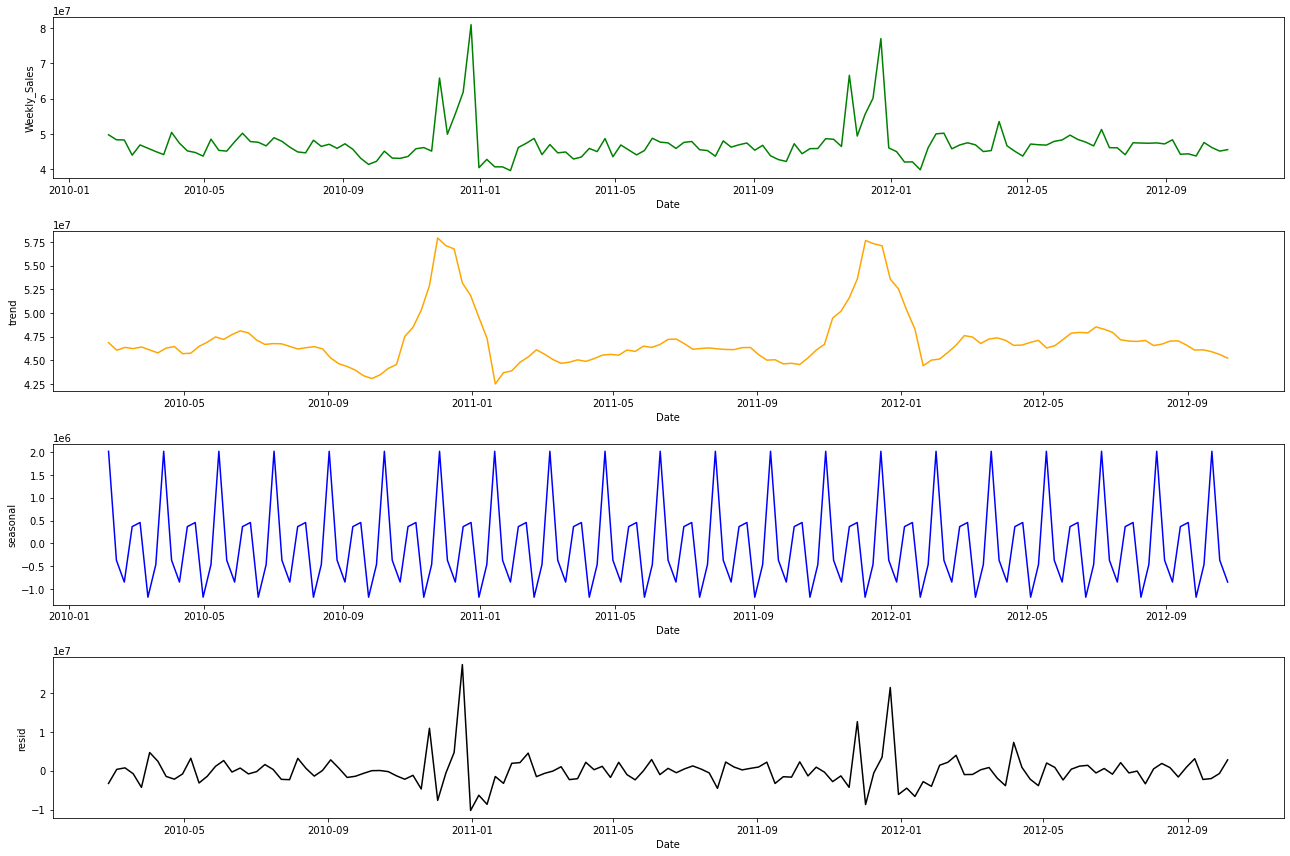

In [44]:
plt.figure(figsize=(18,12))
plt.subplot(4,1,1)
sns.lineplot(x=seas_d.observed.index, y=seas_d.observed, color='green')
plt.subplot(4,1,2)
sns.lineplot(x=seas_d.trend.index, y=seas_d.trend, color='orange')
plt.subplot(4,1,3)
sns.lineplot(x=seas_d.seasonal.index, y=seas_d.seasonal, color='blue')
plt.subplot(4,1,4)
sns.lineplot(x=seas_d.resid.index, y=seas_d.resid, color='black')
plt.tight_layout()

## FBProphet:

In [45]:
pdf = wdf.copy(deep=True)
pdf.drop('forecast',1,inplace=True)
pdf['ds'] = pdf.index
pdf.rename(columns = {'Weekly_Sales':'y'}, inplace=True)
pdf.reset_index(drop=True,inplace=True)
pdf = pdf.reindex(columns=['ds','y'])
pdf.head(2)

,ds,y
0,2010-02-05,49750740.50
1,2010-02-12,48336677.63


In [46]:
m1 = Prophet()
m1.fit(pdf)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [47]:
future1 = m1.make_future_dataframe(periods=52, freq='W')
future1.tail()

,ds
190,2013-09-22
191,2013-09-29
192,2013-10-06
193,2013-10-13
194,2013-10-20


In [48]:
forecast1 = m1.predict(future1)
forecast1[['ds','yhat','yhat_lower','yhat_upper']].head()

,ds,yhat,yhat_lower,yhat_upper
0,2010-02-05,47841357.54,43453782.96,52517677.76
1,2010-02-12,48544242.09,44343409.73,52860773.52
2,2010-02-19,47161315.70,42807768.78,51353021.85
3,2010-02-26,45945916.77,41658808.97,50251532.02
4,2010-03-05,45670165.04,41381701.80,50311992.28


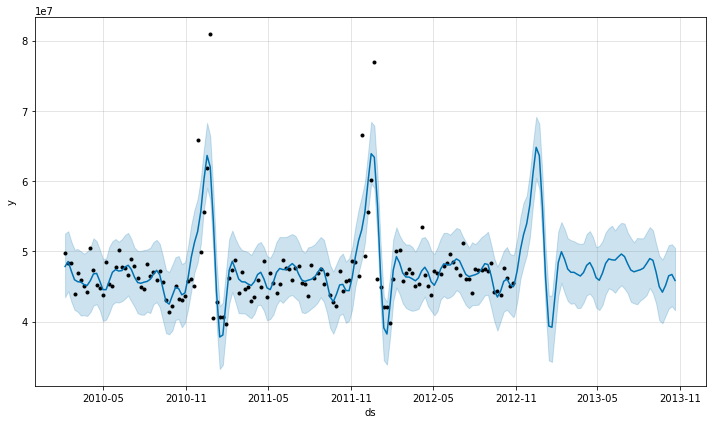

In [49]:
fig1 = m1.plot(forecast1)

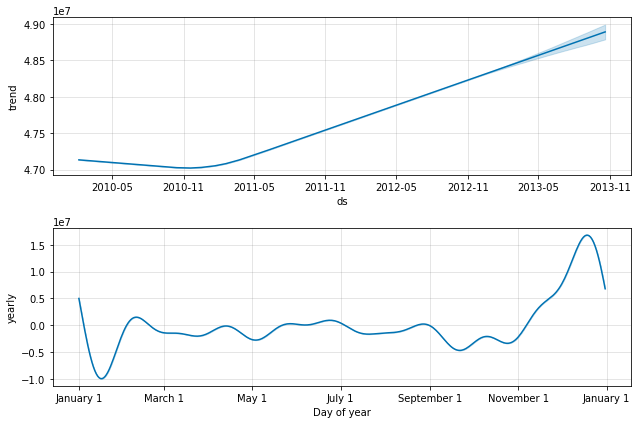

In [50]:
fig2 = m1.plot_components(forecast1)

In [51]:
from fbprophet.diagnostics import cross_validation, performance_metrics

In [52]:
pdfcv = cross_validation(m1, initial = '500 days', period='180 days', horizon='365 days')

INFO:fbprophet:Making 1 forecasts with cutoffs between 2011-10-27 00:00:00 and 2011-10-27 00:00:00


In [53]:
performance_metrics(pdfcv)

,horizon,mse,rmse,mae,mape,mdape,coverage
0,29 days,51753392583982.56,7193983.08,5303256.82,0.09,0.07,0.80
1,36 days,56301576517043.54,7503437.65,5849466.62,0.10,0.09,0.60
2,43 days,56053337749100.37,7486877.70,5820031.52,0.10,0.07,0.60
3,50 days,58372957602236.07,7640219.74,6268253.32,0.11,0.07,0.60
4,57 days,94878118725163.75,9740539.96,8419975.45,0.13,0.11,0.40
5,64 days,70351456074068.10,8387577.49,7429515.98,0.13,0.11,0.40
6,71 days,64277564200289.67,8017328.99,6413081.03,0.11,0.07,0.60
7,78 days,64676872387087.23,8042193.26,6459945.05,0.11,0.10,0.40
8,85 days,67742573344248.02,8230587.67,6796812.75,0.13,0.13,0.20
9,92 days,29683273768728.84,5448235.84,4297222.01,0.10,0.10,0.40


In [54]:
r2_score(pdf['y'], forecast1['yhat'].iloc[:143])

0.5851390904338938